In [1]:
import random
import torch
import datetime
from dataset_utils import generate_dataset
import json
import matplotlib.pyplot as plt
from model import build_transformer
from config import get_config
from dataset import causal_mask, SequencesDataset
from torch.utils.data import random_split, DataLoader
from train import get_ds
import tqdm

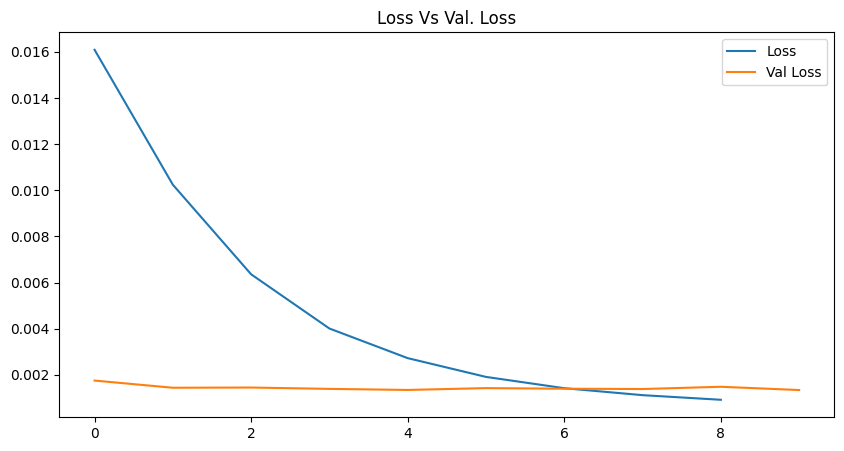

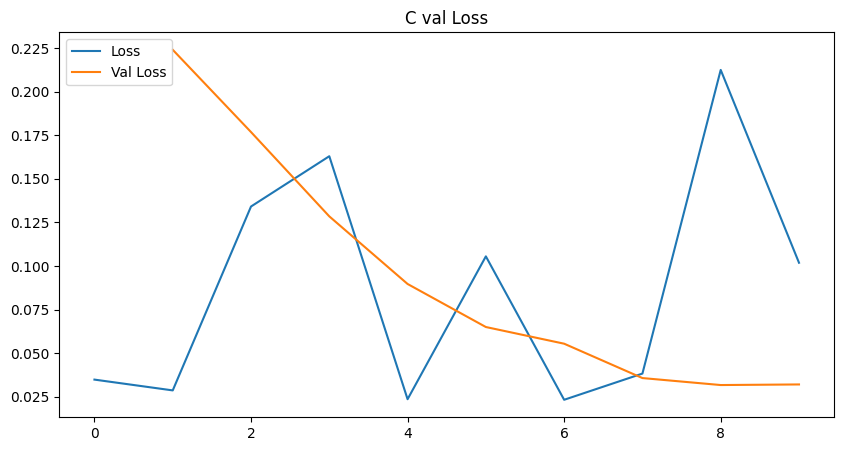

In [2]:
with open("SPX500_USD_checkpoints/results.json", "r") as f:
    results = json.load(f)

results

plt.figure(figsize=(10,5))
plt.title("Loss Vs Val. Loss")
plt.plot(results["loss"][1:], label="Loss")
plt.plot(results["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("C val Loss")
plt.plot(results["val_C_loss"], label="Loss")
plt.plot(results["C_loss"], label="Val Loss")
plt.legend()
plt.show()

In [3]:
config = get_config()
model = build_transformer(config["src_len"], config["tgt_len"], config["input_features"], config["y_size"], config["d_model"], config["N"], config["h"], config["dropout"], config["d_ff"])
state = torch.load("SPX500_USD_checkpoints/algoTransformer_09.pt", map_location=torch.device('cpu'))
model.load_state_dict(state["model_state_dict"])

<All keys matched successfully>

In [4]:
# X_raw, y_raw = (config["security"], config["provider"], config["src_len"], config["tgt_len"], config["start_year"], config["end_year"]) # generate raw dataset

train_dataloader, test_dataloader, val_dataloader = get_ds(config)

Checking for existing dataset...
Found existing dataset at  datasets/SPX500_USD_2000-2024_256-32.npy . Loading...
Dataset loaded


In [8]:
def inference_decoding(model, source, source_mask, seq_len, device):

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)  #(Batch, src_len, d_model)
    # Initialize the decoder input
    decoder_input = torch.zeros(encoder_output.shape[0], 1, 4).type_as(source).to(device)
    while True: # Autoregressive generation
        if decoder_input.size(1) == seq_len:
            break
        
        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).bool().to(device) 

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next element in the sequence
        next_element = model.project(out[:, -1]) # è già sul device? in caso rimuovere il .to(device) che c'è sotto
        decoder_input = torch.cat([decoder_input, next_element.unsqueeze(1).to(device)], dim = 1) # da capire la dimensione di next_element
    
    return decoder_input

def calculate_batch_cumulative_returns(proj_output, label):

    adjusted_predicted_returns = 1 + proj_output[:, :, 0] # for now we assume close is in 0 dimension
    adjusted_actual_returns = 1 + label[:, :, 0]

    cumulative_predicted_compound_returns = torch.cumprod(adjusted_predicted_returns, dim = -1)
    cumulative_actual_compound_returns = torch.cumprod(adjusted_actual_returns, dim = -1)

    cumulative_predicted_compound_returns -= 1
    cumulative_actual_compound_returns -= 1

    return cumulative_predicted_compound_returns, cumulative_actual_compound_returns 


In [9]:
def classify_cumulative_returns(cumulative_predicted_compound_returns, cumulative_actual_compound_returns):

    """Works with batches"""
    
    cumulative_predicted_compound_returns = cumulative_predicted_compound_returns[:, -1]
    cumulative_actual_compound_returns = cumulative_actual_compound_returns[:, -1]
    pred_classes = cumulative_predicted_compound_returns >= 0
    actual_classes = cumulative_actual_compound_returns >= 0
    
    return pred_classes, actual_classes

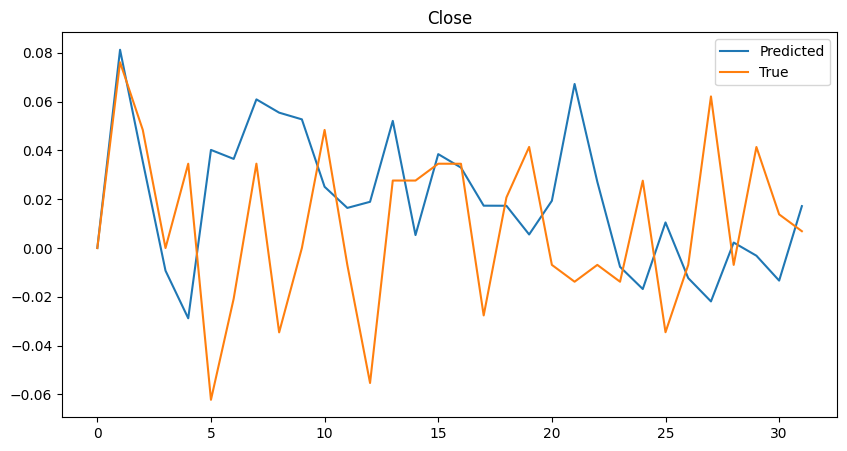

Pred return tensor([[0.0000, 0.0813, 0.1196, 0.1092, 0.0773, 0.1206, 0.1616, 0.2323, 0.3007,
         0.3693, 0.4037, 0.4268, 0.4539, 0.5296, 0.5378, 0.5970, 0.6497, 0.6783,
         0.7074, 0.7169, 0.7501, 0.8678, 0.9185, 0.9037, 0.8718, 0.8914, 0.8681,
         0.8272, 0.8313, 0.8256, 0.8012, 0.8322]], grad_fn=<SubBackward0>)
Actual returns: tensor([[0.0000, 0.0762, 0.1283, 0.1283, 0.1673, 0.0947, 0.0720, 0.1090, 0.0707,
         0.0707, 0.1225, 0.1148, 0.0531, 0.0822, 0.1122, 0.1506, 0.1904, 0.1575,
         0.1815, 0.2304, 0.2219, 0.2051, 0.1968, 0.1802, 0.2128, 0.1710, 0.1629,
         0.2351, 0.2266, 0.2774, 0.2951, 0.3040]])


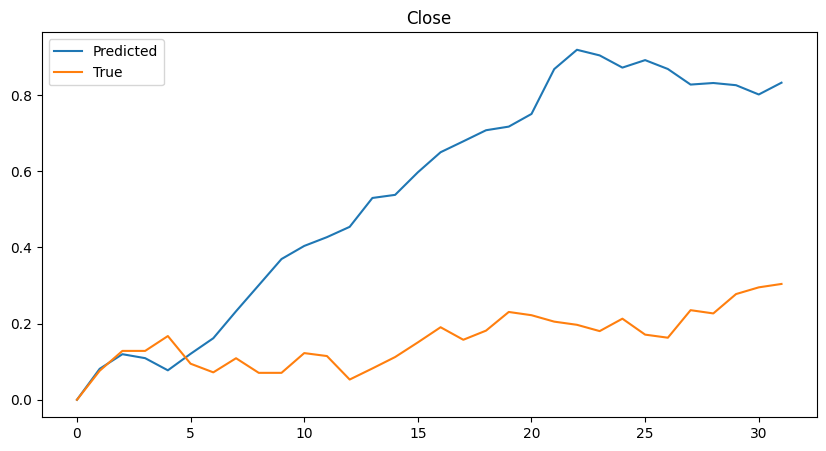

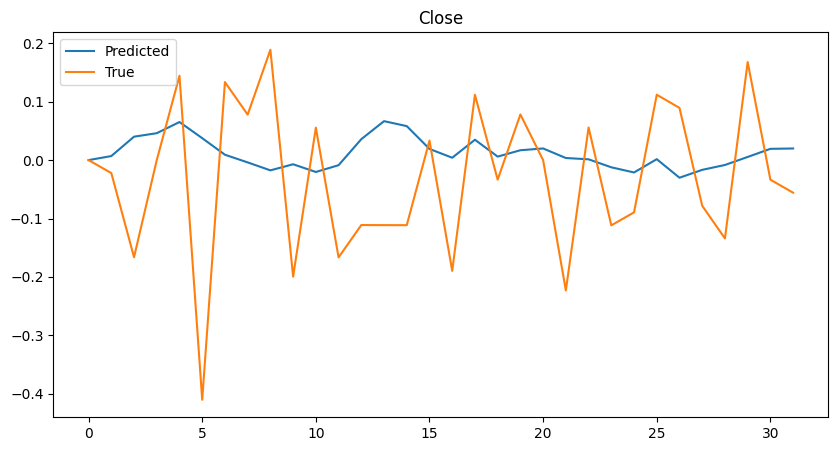

Pred return tensor([[0.0000, 0.0069, 0.0473, 0.0956, 0.1670, 0.2108, 0.2220, 0.2172, 0.1958,
         0.1873, 0.1631, 0.1530, 0.1944, 0.2740, 0.3481, 0.3739, 0.3795, 0.4276,
         0.4362, 0.4604, 0.4896, 0.4949, 0.4969, 0.4785, 0.4472, 0.4495, 0.4058,
         0.3824, 0.3708, 0.3782, 0.4048, 0.4328]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0222, -0.1848, -0.1848, -0.0671, -0.4499, -0.3765, -0.3279,
         -0.2010, -0.3604, -0.3249, -0.4374, -0.4999, -0.5556, -0.6051, -0.5919,
         -0.6693, -0.6323, -0.6446, -0.6168, -0.6168, -0.7024, -0.6857, -0.7208,
         -0.7458, -0.7174, -0.6921, -0.7162, -0.7542, -0.7130, -0.7226, -0.7381]])


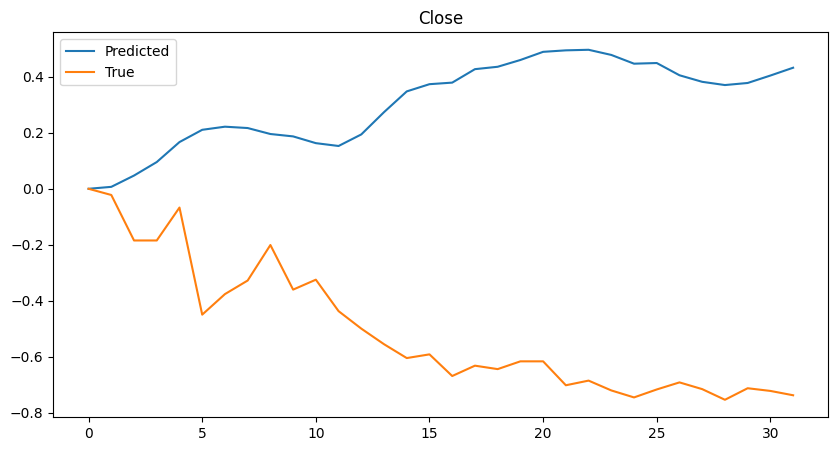

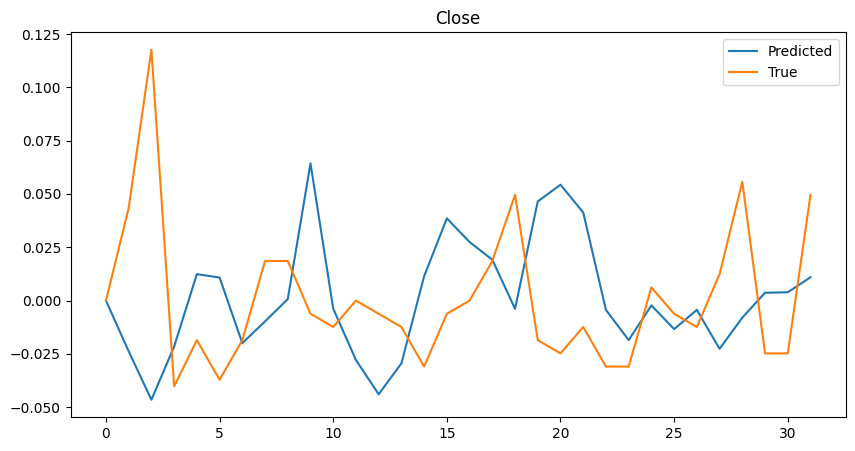

Pred return tensor([[ 0.0000, -0.0238, -0.0692, -0.0892, -0.0780, -0.0680, -0.0866, -0.0955,
         -0.0949, -0.0367, -0.0403, -0.0670, -0.1080, -0.1343, -0.1244, -0.0906,
         -0.0657, -0.0478, -0.0514, -0.0073,  0.0466,  0.0898,  0.0850,  0.0649,
          0.0625,  0.0483,  0.0437,  0.0201,  0.0120,  0.0157,  0.0196,  0.0308]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0433,  0.1660,  0.1192,  0.0984,  0.0576,  0.0380,  0.0573,
          0.0769,  0.0702,  0.0570,  0.0570,  0.0505,  0.0375,  0.0053, -0.0009,
         -0.0009,  0.0177,  0.0681,  0.0482,  0.0223,  0.0096, -0.0216, -0.0519,
         -0.0460, -0.0519, -0.0637, -0.0521,  0.0008, -0.0240, -0.0482, -0.0010]])


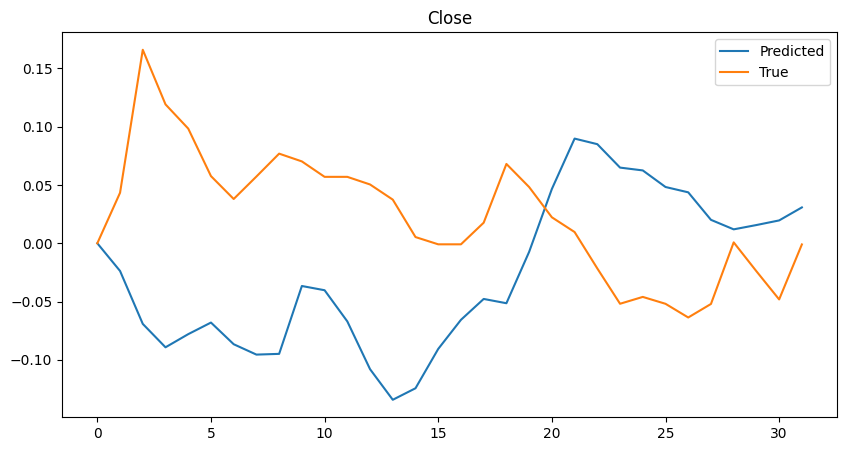

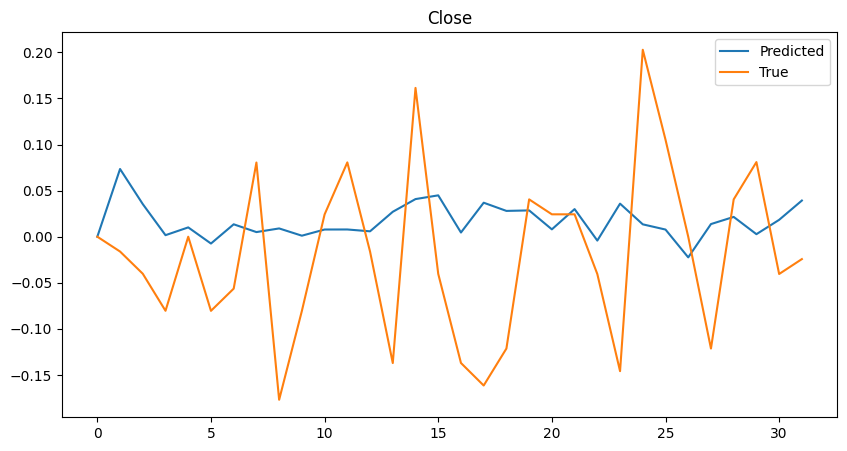

Pred return tensor([[0.0000, 0.0735, 0.1114, 0.1133, 0.1245, 0.1162, 0.1313, 0.1369, 0.1472,
         0.1484, 0.1574, 0.1665, 0.1733, 0.2051, 0.2543, 0.3105, 0.3165, 0.3651,
         0.4033, 0.4433, 0.4549, 0.4984, 0.4922, 0.5457, 0.5665, 0.5786, 0.5432,
         0.5644, 0.5980, 0.6024, 0.6317, 0.6958]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0161, -0.0556, -0.1315, -0.1315, -0.2013, -0.2463, -0.1857,
         -0.3297, -0.3837, -0.3688, -0.3179, -0.3289, -0.4209, -0.3274, -0.3545,
         -0.4429, -0.5328, -0.5895, -0.5729, -0.5625, -0.5519, -0.5700, -0.6327,
         -0.5582, -0.5117, -0.5117, -0.5710, -0.5536, -0.5175, -0.5370, -0.5482]])


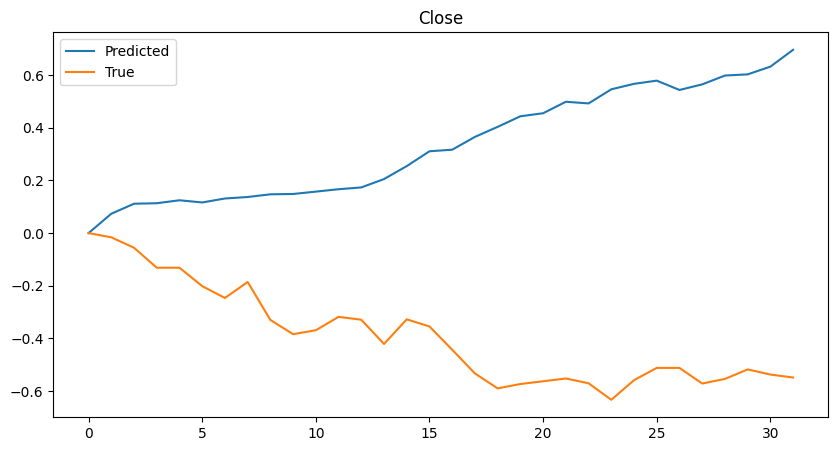

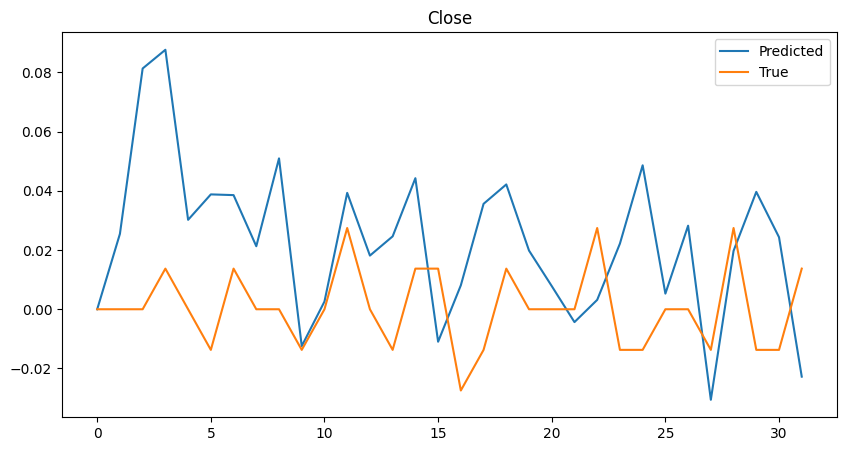

Pred return tensor([[0.0000, 0.0255, 0.1089, 0.2061, 0.2425, 0.2907, 0.3405, 0.3690, 0.4388,
         0.4209, 0.4246, 0.4806, 0.5075, 0.5446, 0.6130, 0.5953, 0.6082, 0.6654,
         0.7357, 0.7701, 0.7839, 0.7762, 0.7818, 0.8213, 0.9099, 0.9200, 0.9742,
         0.9138, 0.9516, 1.0290, 1.0784, 1.0310]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0000,  0.0000,  0.0137,  0.0137, -0.0002,  0.0135,  0.0135,
          0.0135, -0.0004, -0.0004,  0.0271,  0.0271,  0.0130,  0.0269,  0.0410,
          0.0124, -0.0015,  0.0122,  0.0122,  0.0122,  0.0122,  0.0400,  0.0257,
          0.0116,  0.0116,  0.0116, -0.0022,  0.0252,  0.0111, -0.0028,  0.0109]])


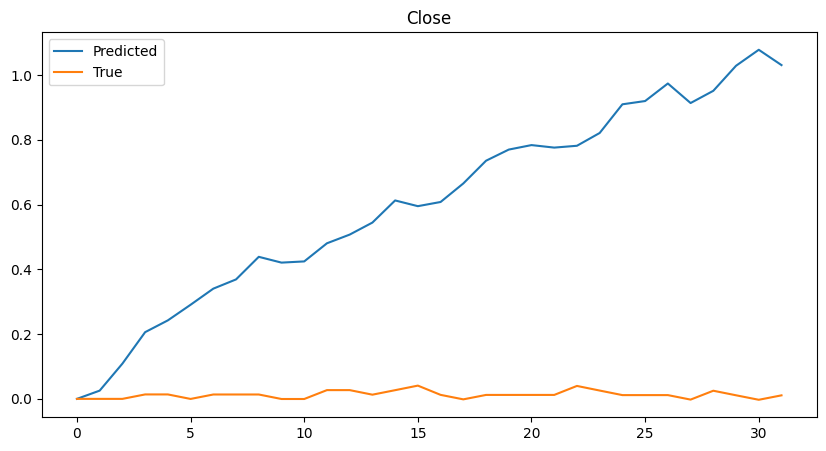

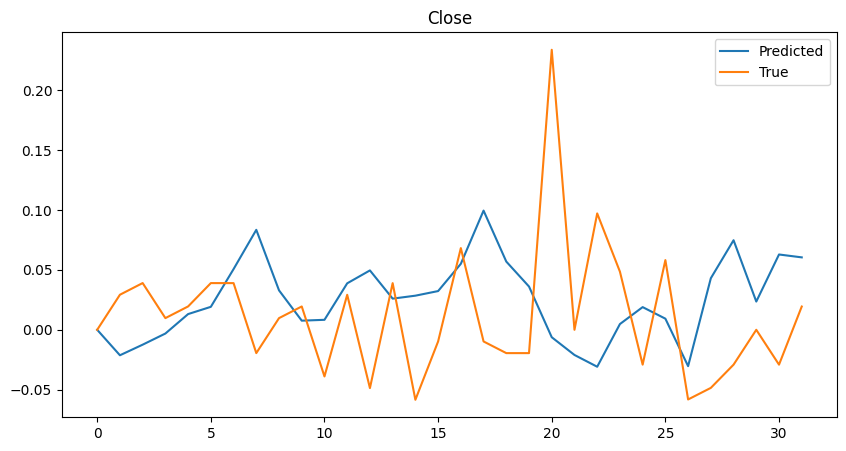

Pred return tensor([[ 0.0000, -0.0213, -0.0334, -0.0364, -0.0238, -0.0051,  0.0453,  0.1326,
          0.1699,  0.1788,  0.1886,  0.2347,  0.2959,  0.3297,  0.3675,  0.4117,
          0.4895,  0.6377,  0.7310,  0.7935,  0.7824,  0.7449,  0.6911,  0.6992,
          0.7314,  0.7474,  0.6944,  0.7674,  0.8995,  0.9443,  1.0666,  1.1915]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[0.0000, 0.0293, 0.0694, 0.0799, 0.1009, 0.1438, 0.1884, 0.1653, 0.1766,
         0.1995, 0.1528, 0.1865, 0.1288, 0.1727, 0.1042, 0.0935, 0.1680, 0.1567,
         0.1341, 0.1121, 0.3720, 0.3720, 0.5053, 0.5784, 0.5325, 0.6216, 0.5273,
         0.4533, 0.4110, 0.4110, 0.3699, 0.3965]])


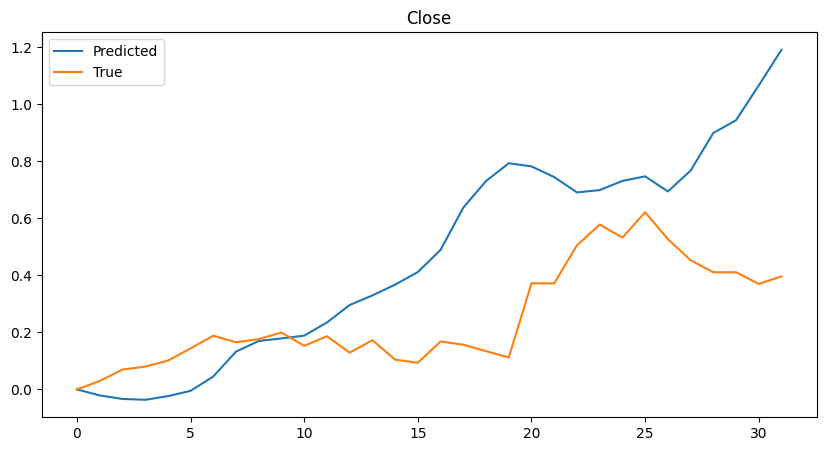

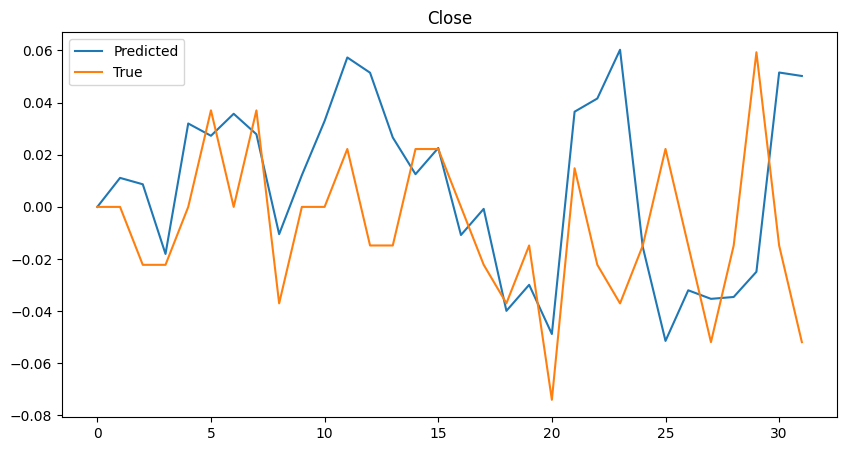

Pred return tensor([[0.0000, 0.0111, 0.0199, 0.0015, 0.0335, 0.0617, 0.0996, 0.1303, 0.1185,
         0.1321, 0.1694, 0.2364, 0.3000, 0.3346, 0.3514, 0.3819, 0.3670, 0.3660,
         0.3115, 0.2723, 0.2103, 0.2544, 0.3066, 0.3853, 0.3641, 0.2939, 0.2525,
         0.2084, 0.1666, 0.1376, 0.1962, 0.2563]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0000, -0.0222, -0.0440, -0.0440, -0.0085, -0.0085,  0.0282,
         -0.0099, -0.0099, -0.0099,  0.0121, -0.0029, -0.0176,  0.0042,  0.0265,
          0.0265,  0.0037, -0.0334, -0.0477, -0.1182, -0.1051, -0.1250, -0.1574,
         -0.1699, -0.1514, -0.1640, -0.2074, -0.2191, -0.1728, -0.1851, -0.2273]])


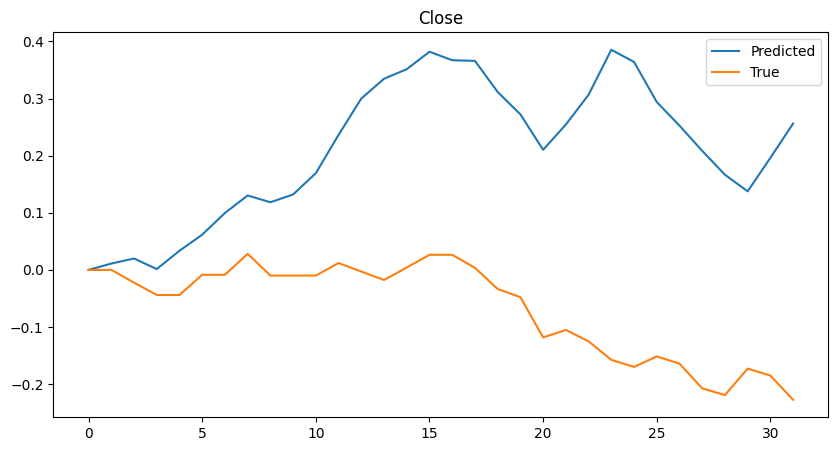

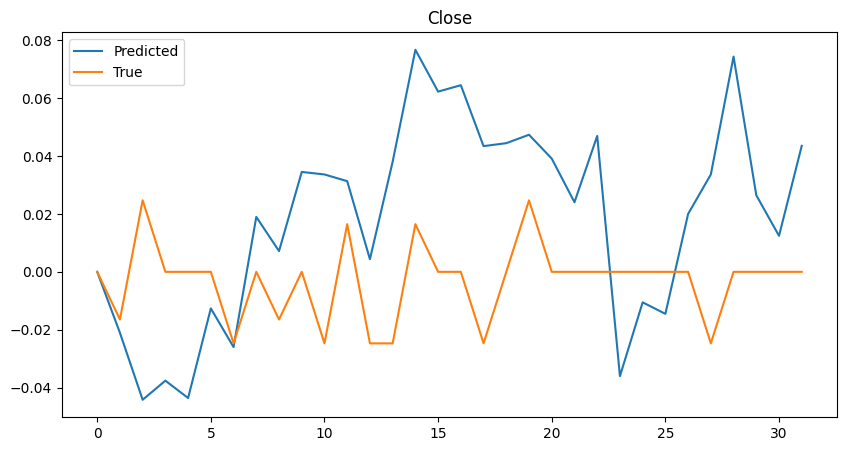

Pred return tensor([[ 0.0000, -0.0211, -0.0644, -0.0996, -0.1388, -0.1497, -0.1718, -0.1561,
         -0.1501, -0.1207, -0.0911, -0.0626, -0.0585, -0.0226,  0.0524,  0.1180,
          0.1901,  0.2418,  0.2971,  0.3586,  0.4118,  0.4457,  0.5137,  0.4591,
          0.4437,  0.4227,  0.4512,  0.5001,  0.6117,  0.6544,  0.6750,  0.7480]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0165,  0.0078,  0.0078,  0.0078,  0.0078, -0.0171, -0.0171,
         -0.0333, -0.0333, -0.0572, -0.0416, -0.0653, -0.0884, -0.0734, -0.0734,
         -0.0734, -0.0963, -0.0963, -0.0740, -0.0740, -0.0740, -0.0740, -0.0740,
         -0.0740, -0.0740, -0.0740, -0.0969, -0.0969, -0.0969, -0.0969, -0.0969]])


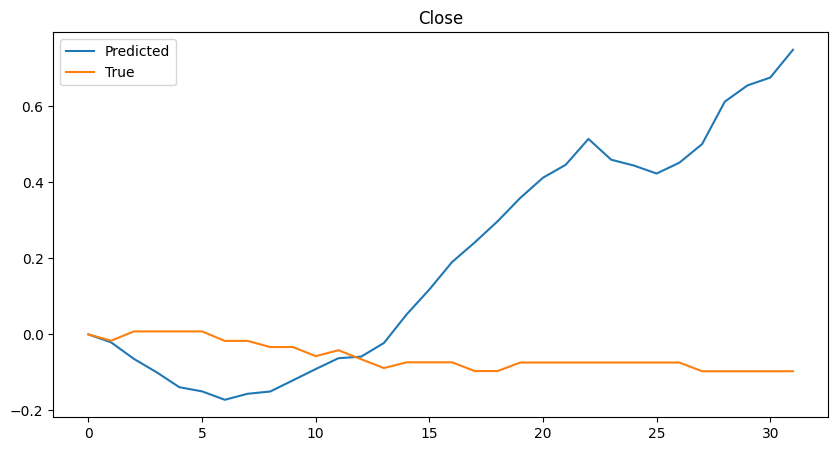

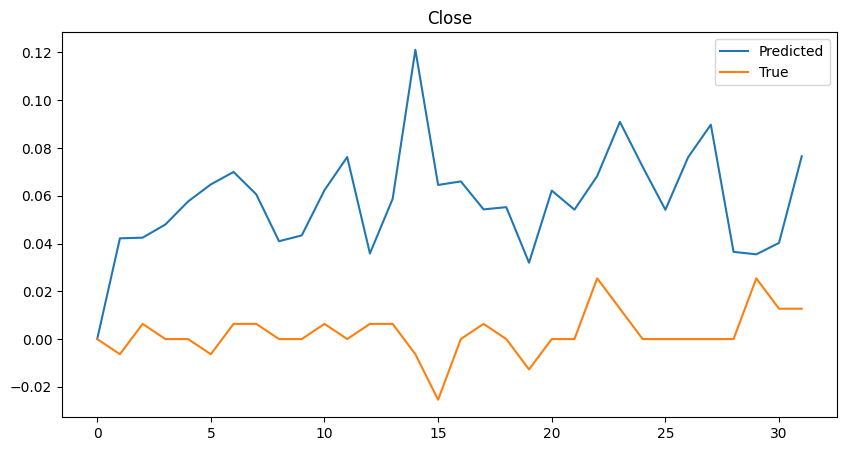

Pred return tensor([[0.0000, 0.0422, 0.0864, 0.1386, 0.2042, 0.2822, 0.3719, 0.4550, 0.5146,
         0.5803, 0.6788, 0.8068, 0.8716, 0.9815, 1.2215, 1.3649, 1.5210, 1.6579,
         1.8047, 1.8944, 2.0743, 2.2409, 2.4622, 2.7771, 3.0496, 3.2688, 3.5937,
         4.0061, 4.1889, 4.3730, 4.5894, 5.0172]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000e+00, -6.3549e-03, -3.9637e-05, -3.9637e-05, -3.9637e-05,
         -6.3942e-03, -7.9215e-05,  6.2759e-03,  6.2759e-03,  6.2759e-03,
          1.2673e-02,  1.2673e-02,  1.9109e-02,  2.5586e-02,  1.9068e-02,
         -6.8389e-03, -6.8389e-03, -5.2512e-04, -5.2512e-04, -1.3232e-02,
         -1.3232e-02, -1.3232e-02,  1.1860e-02,  2.4724e-02,  2.4724e-02,
          2.4724e-02,  2.4724e-02,  2.4724e-02,  2.4724e-02,  5.0774e-02,
          6.4128e-02,  7.7650e-02]])


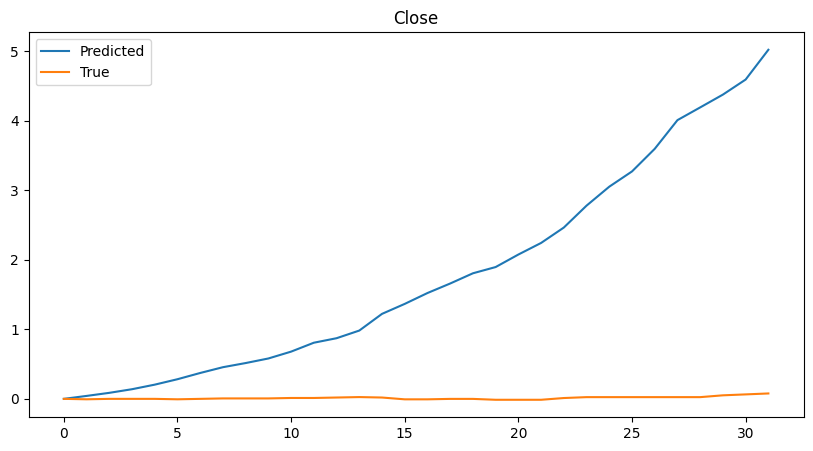

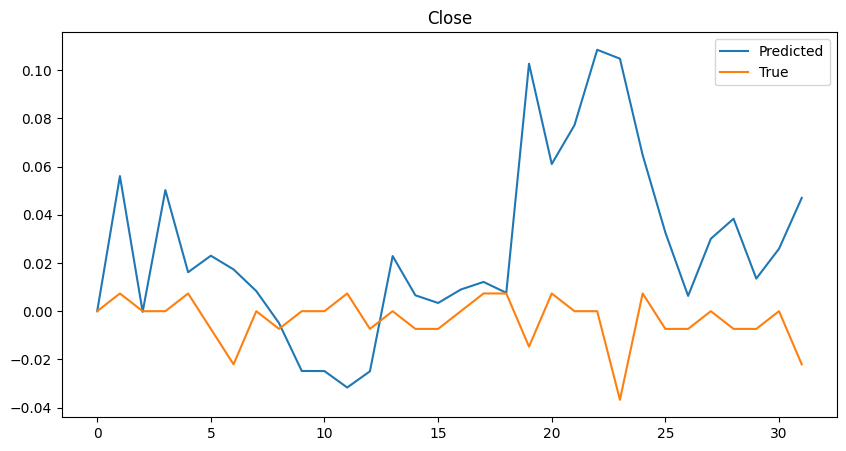

Pred return tensor([[0.0000, 0.0560, 0.0558, 0.1088, 0.1267, 0.1527, 0.1726, 0.1824, 0.1766,
         0.1474, 0.1189, 0.0834, 0.0564, 0.0805, 0.0877, 0.0914, 0.1012, 0.1145,
         0.1230, 0.2383, 0.3140, 0.4154, 0.5689, 0.7333, 0.8456, 0.9058, 0.9178,
         0.9755, 1.0513, 1.0790, 1.1329, 1.2331]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0073,  0.0073,  0.0073,  0.0148,  0.0073, -0.0149, -0.0149,
         -0.0222, -0.0222, -0.0222, -0.0150, -0.0222, -0.0222, -0.0294, -0.0365,
         -0.0365, -0.0295, -0.0223, -0.0367, -0.0296, -0.0296, -0.0296, -0.0653,
         -0.0584, -0.0653, -0.0722, -0.0722, -0.0790, -0.0858, -0.0858, -0.1060]])


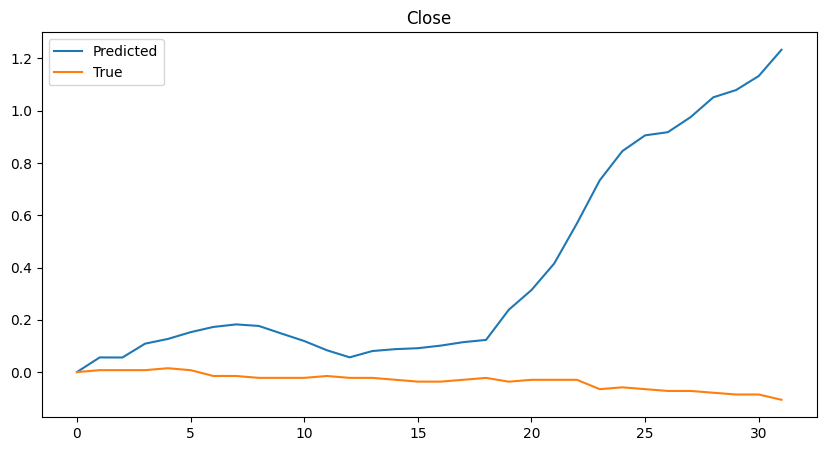

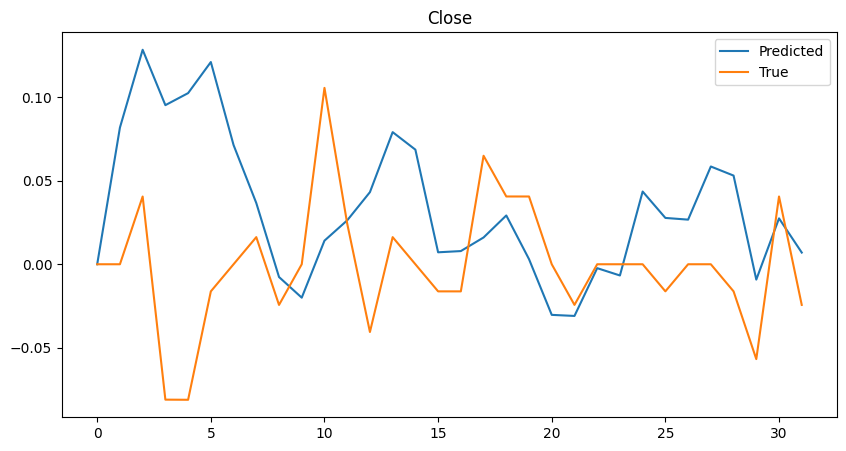

Pred return tensor([[0.0000, 0.0818, 0.2206, 0.3368, 0.4737, 0.6520, 0.7698, 0.8346, 0.8206,
         0.7842, 0.8094, 0.8569, 0.9370, 1.0902, 1.2335, 1.2495, 1.2672, 1.3035,
         1.3708, 1.3780, 1.3060, 1.2347, 1.2295, 1.2145, 1.3109, 1.3749, 1.4383,
         1.5809, 1.7179, 1.6929, 1.7668, 1.7862]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0000,  0.0405, -0.0438, -0.1213, -0.1356, -0.1356, -0.1215,
         -0.1429, -0.1429, -0.0525, -0.0294, -0.0688, -0.0536, -0.0536, -0.0690,
         -0.0841, -0.0247,  0.0149,  0.0560,  0.0560,  0.0304,  0.0304,  0.0304,
          0.0304,  0.0137,  0.0137,  0.0137, -0.0028, -0.0594, -0.0212, -0.0450]])


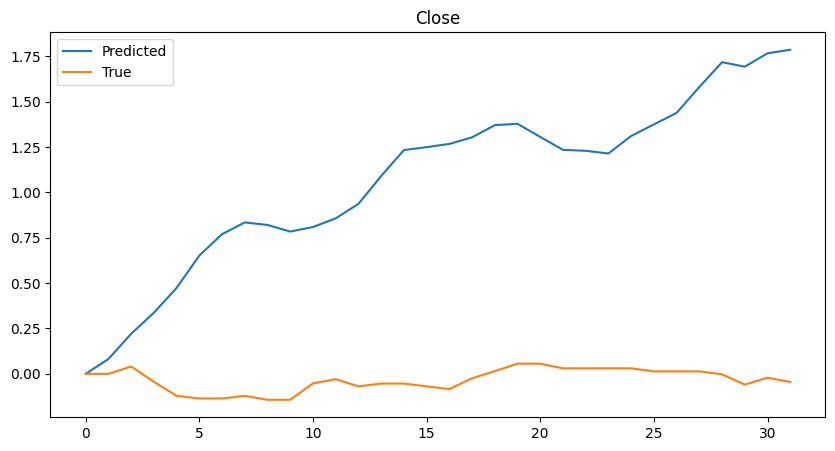

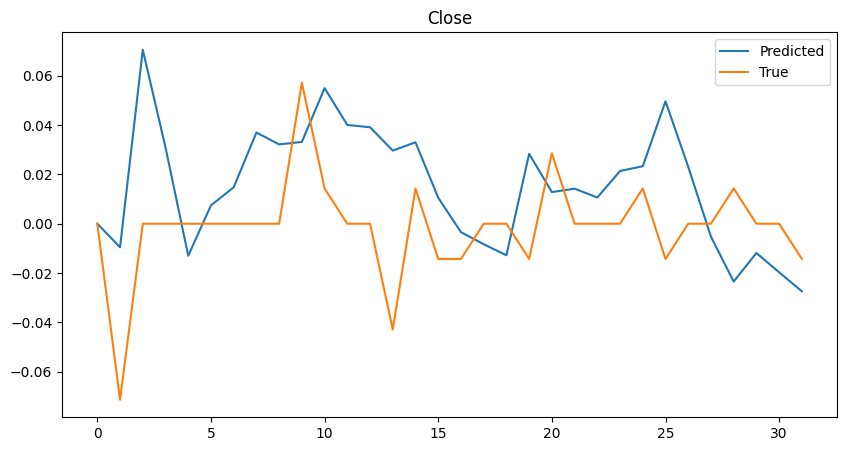

Pred return tensor([[ 0.0000, -0.0096,  0.0603,  0.0932,  0.0790,  0.0870,  0.1030,  0.1438,
          0.1807,  0.2198,  0.2869,  0.3384,  0.3908,  0.4321,  0.4793,  0.4949,
          0.4898,  0.4774,  0.4585,  0.4998,  0.5191,  0.5407,  0.5571,  0.5904,
          0.6275,  0.7083,  0.7477,  0.7385,  0.6977,  0.6776,  0.6445,  0.5994]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0714, -0.0714, -0.0714, -0.0714, -0.0714, -0.0714, -0.0714,
         -0.0714, -0.0183, -0.0042, -0.0042, -0.0042, -0.0469, -0.0333, -0.0471,
         -0.0608, -0.0608, -0.0608, -0.0742, -0.0477, -0.0477, -0.0477, -0.0477,
         -0.0341, -0.0479, -0.0479, -0.0479, -0.0343, -0.0343, -0.0343, -0.0481]])


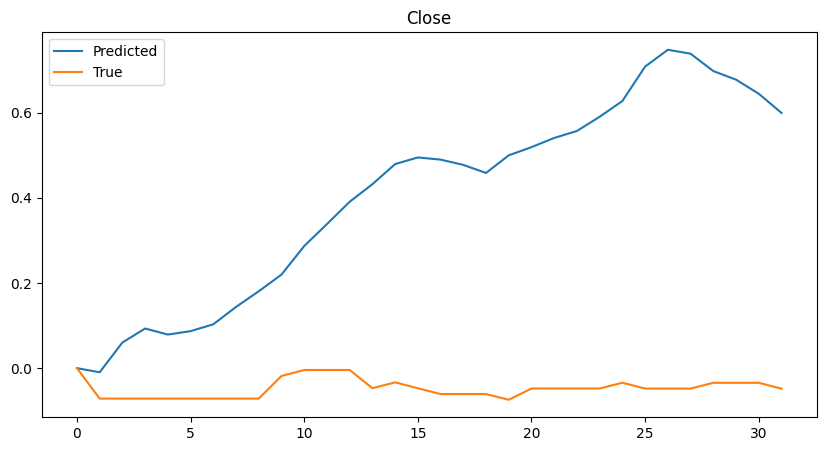

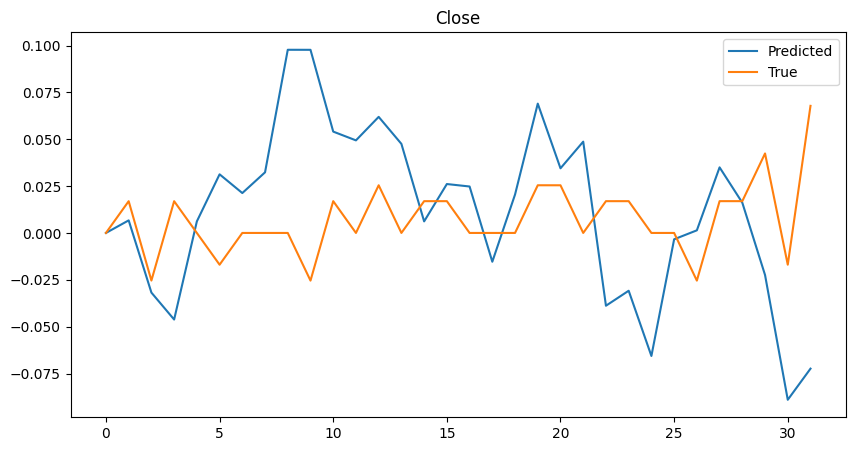

Pred return tensor([[ 0.0000,  0.0067, -0.0253, -0.0704, -0.0646, -0.0354, -0.0148,  0.0170,
          0.1164,  0.2255,  0.2917,  0.3555,  0.4395,  0.5079,  0.5172,  0.5568,
          0.5954,  0.5708,  0.6030,  0.7136,  0.7727,  0.8591,  0.7869,  0.7318,
          0.6181,  0.6126,  0.6149,  0.6714,  0.6984,  0.6603,  0.5125,  0.4030]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0169, -0.0089,  0.0079,  0.0079, -0.0092, -0.0092, -0.0092,
         -0.0092, -0.0344, -0.0180, -0.0180,  0.0070,  0.0070,  0.0241,  0.0414,
          0.0414,  0.0414,  0.0414,  0.0679,  0.0951,  0.0951,  0.1136,  0.1325,
          0.1325,  0.1325,  0.1037,  0.1224,  0.1415,  0.1899,  0.1697,  0.2490]])


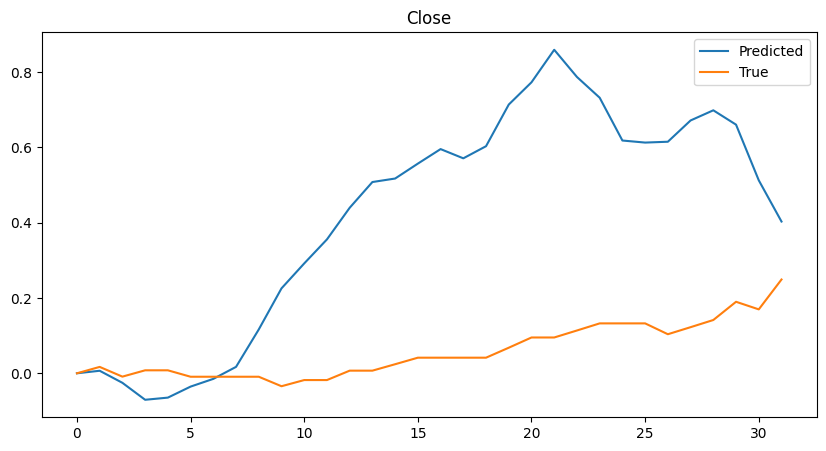

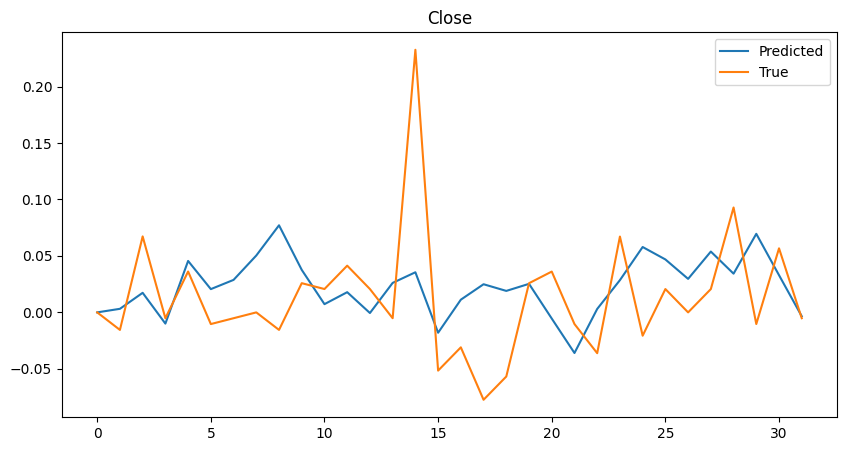

Pred return tensor([[0.0000, 0.0032, 0.0205, 0.0104, 0.0564, 0.0782, 0.1092, 0.1651, 0.2550,
         0.3022, 0.3117, 0.3352, 0.3344, 0.3693, 0.4179, 0.3924, 0.4080, 0.4431,
         0.4706, 0.5078, 0.4995, 0.4456, 0.4500, 0.4914, 0.5778, 0.6517, 0.7008,
         0.7924, 0.8538, 0.9828, 1.0482, 1.0412]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0155,  0.0507,  0.0453,  0.0831,  0.0719,  0.0664,  0.0664,
          0.0498,  0.0770,  0.0993,  0.1448,  0.1684,  0.1624,  0.4327,  0.3589,
          0.3168,  0.2149,  0.1459,  0.1755,  0.2179,  0.2054,  0.1618,  0.2398,
          0.2142,  0.2393,  0.2393,  0.2649,  0.3824,  0.3681,  0.4457,  0.4383]])


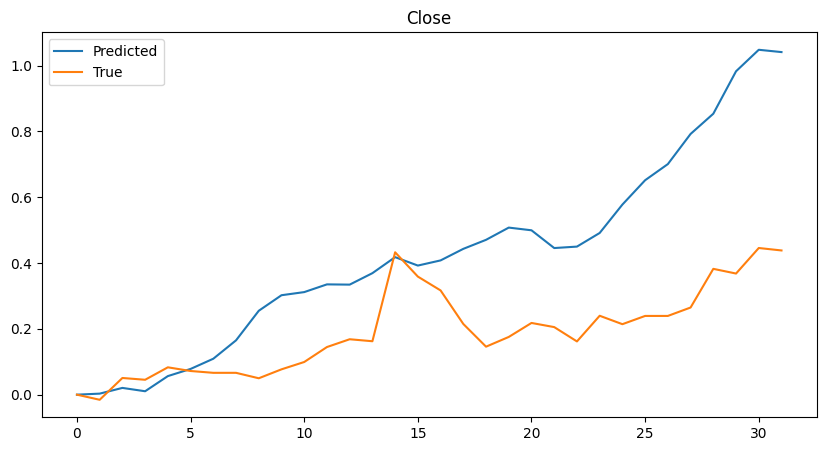

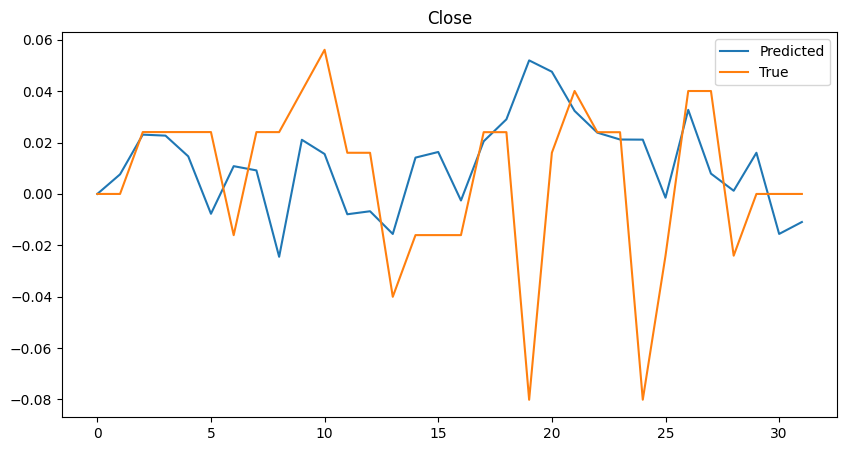

Pred return tensor([[0.0000, 0.0076, 0.0309, 0.0543, 0.0697, 0.0615, 0.0729, 0.0828, 0.0563,
         0.0785, 0.0953, 0.0866, 0.0793, 0.0625, 0.0775, 0.0951, 0.0923, 0.1147,
         0.1471, 0.2067, 0.2642, 0.3050, 0.3361, 0.3645, 0.3933, 0.3913, 0.4368,
         0.4482, 0.4500, 0.4732, 0.4503, 0.4344]], grad_fn=<SubBackward0>)
Actual returns: tensor([[0.0000, 0.0000, 0.0241, 0.0487, 0.0740, 0.0999, 0.0822, 0.1083, 0.1349,
         0.1805, 0.2467, 0.2667, 0.2870, 0.2354, 0.2156, 0.1962, 0.1770, 0.2053,
         0.2343, 0.1354, 0.1536, 0.1998, 0.2287, 0.2582, 0.1574, 0.1296, 0.1749,
         0.2219, 0.1926, 0.1926, 0.1926, 0.1926]])


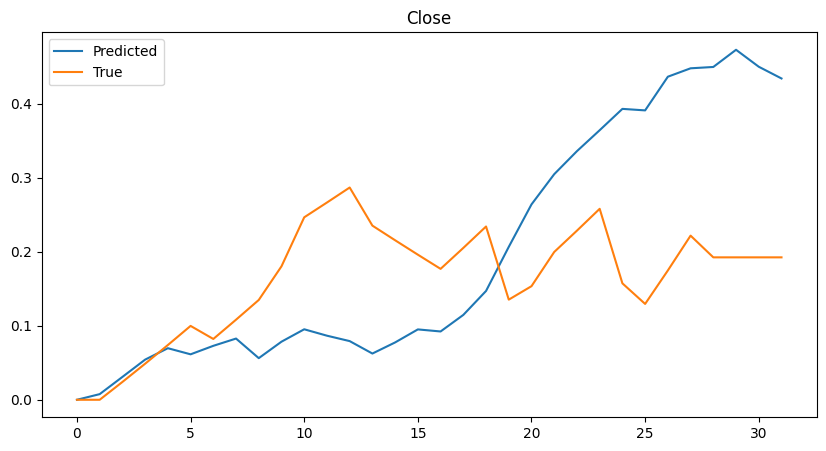

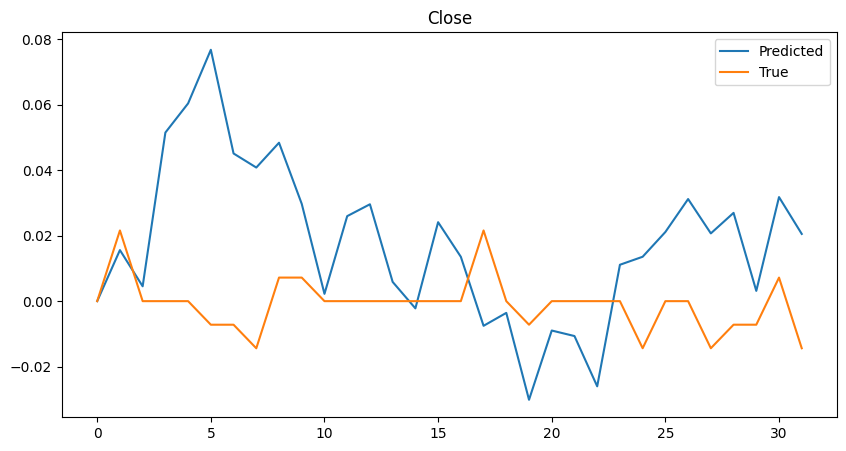

Pred return tensor([[0.0000, 0.0156, 0.0202, 0.0727, 0.1374, 0.2247, 0.2799, 0.3321, 0.3966,
         0.4380, 0.4412, 0.4787, 0.5224, 0.5313, 0.5280, 0.5648, 0.5860, 0.5740,
         0.5684, 0.5212, 0.5075, 0.4915, 0.4527, 0.4688, 0.4887, 0.5202, 0.5675,
         0.6000, 0.6431, 0.6482, 0.7006, 0.7355]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0216,  0.0216,  0.0216,  0.0216,  0.0142,  0.0069, -0.0076,
         -0.0004,  0.0068,  0.0068,  0.0068,  0.0068,  0.0068,  0.0068,  0.0068,
          0.0068,  0.0285,  0.0285,  0.0211,  0.0211,  0.0211,  0.0211,  0.0211,
          0.0064,  0.0064,  0.0064, -0.0080, -0.0152, -0.0223, -0.0152, -0.0294]])


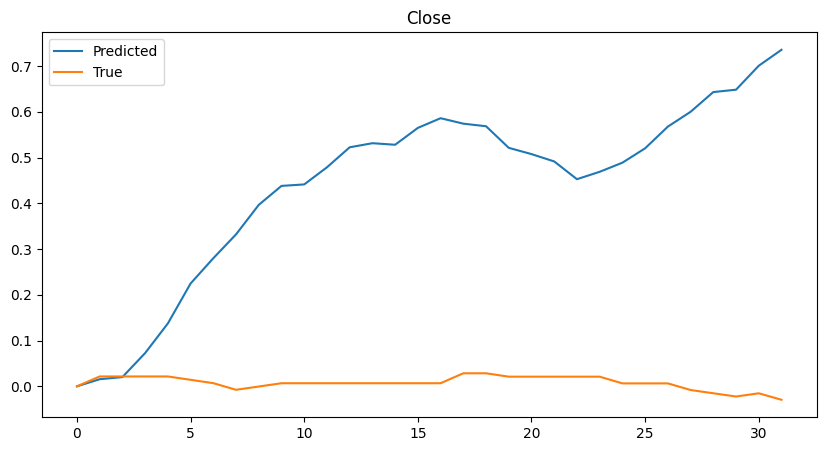

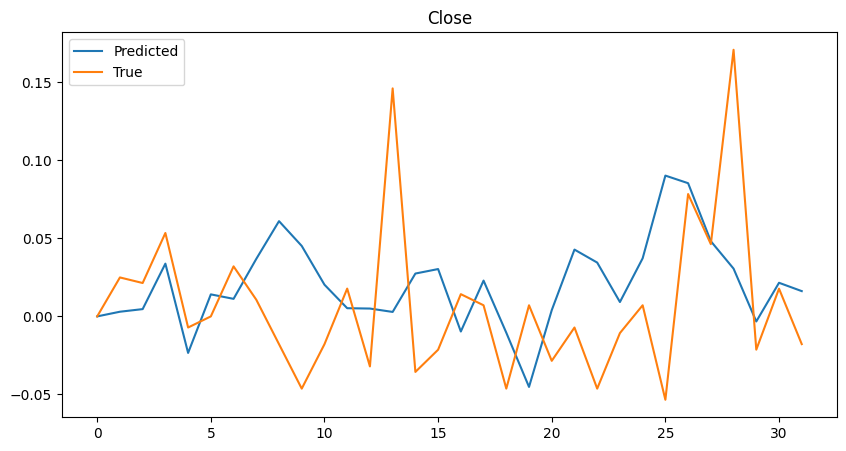

Pred return tensor([[0.0000, 0.0030, 0.0077, 0.0417, 0.0173, 0.0317, 0.0433, 0.0817, 0.1476,
         0.1994, 0.2237, 0.2302, 0.2363, 0.2399, 0.2739, 0.3125, 0.2998, 0.3296,
         0.3157, 0.2563, 0.2613, 0.3152, 0.3606, 0.3731, 0.4241, 0.5525, 0.6849,
         0.7660, 0.8200, 0.8141, 0.8532, 0.8832]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000e+00,  2.4940e-02,  4.6842e-02,  1.0275e-01,  9.4897e-02,
          9.4897e-02,  1.2997e-01,  1.4203e-01,  1.2172e-01,  6.9834e-02,
          5.0792e-02,  6.9495e-02,  3.5233e-02,  1.8636e-01,  1.4417e-01,
          1.1976e-01,  1.3569e-01,  1.4377e-01,  9.0891e-02,  9.8654e-02,
          6.7389e-02,  5.9793e-02,  1.0776e-02, -1.6451e-05,  7.1034e-03,
         -4.6662e-02,  2.8024e-02,  7.5572e-02,  2.5918e-01,  2.3236e-01,
          2.5423e-01,  2.3198e-01]])


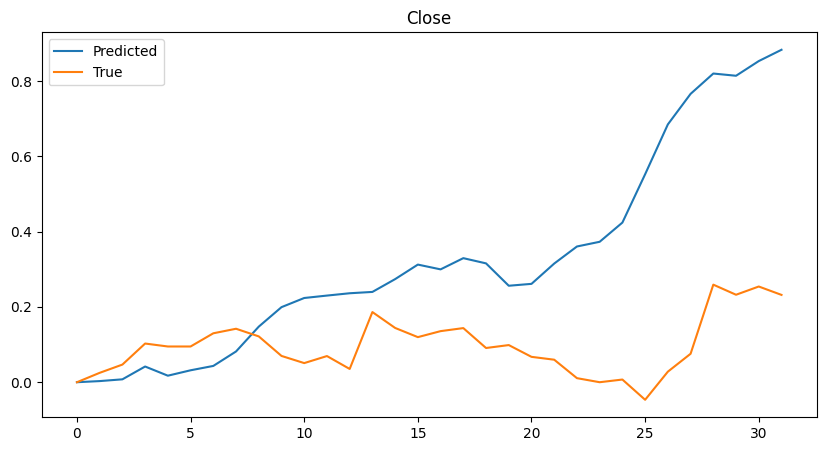

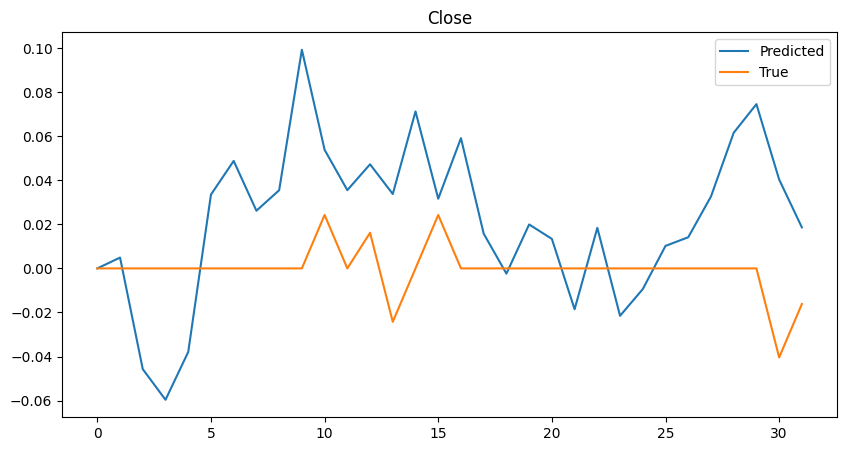

Pred return tensor([[ 0.0000e+00,  4.9137e-03, -4.1034e-02, -9.8209e-02, -1.3240e-01,
         -1.0334e-01, -5.9601e-02, -3.4984e-02, -7.5597e-04,  9.8384e-02,
          1.5750e-01,  1.9862e-01,  2.5525e-01,  2.9762e-01,  3.9006e-01,
          4.3401e-01,  5.1876e-01,  5.4270e-01,  5.3904e-01,  5.6973e-01,
          5.9074e-01,  5.6125e-01,  5.8998e-01,  5.5578e-01,  5.4117e-01,
          5.5690e-01,  5.7890e-01,  6.3039e-01,  7.3073e-01,  8.5975e-01,
          9.3479e-01,  9.7080e-01]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0243,  0.0243,  0.0408,  0.0156,  0.0156,  0.0402,
          0.0402,  0.0402,  0.0402,  0.0402,  0.0402,  0.0402,  0.0402,  0.0402,
          0.0402,  0.0402,  0.0402,  0.0402,  0.0402,  0.0402, -0.0018, -0.0180]])


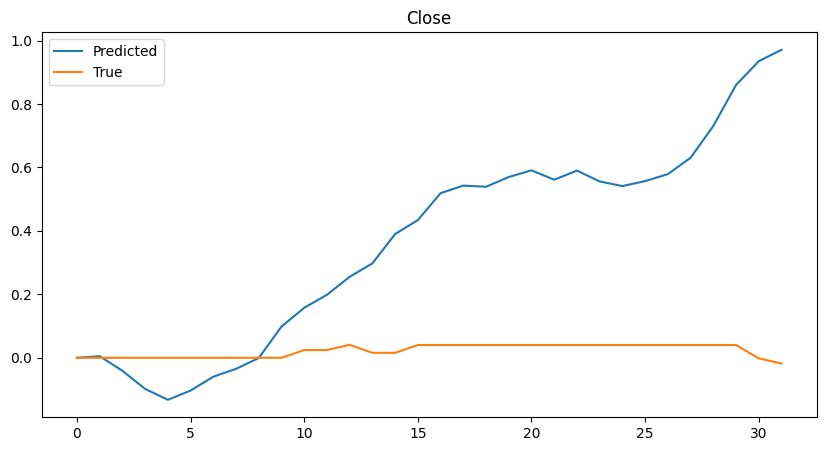

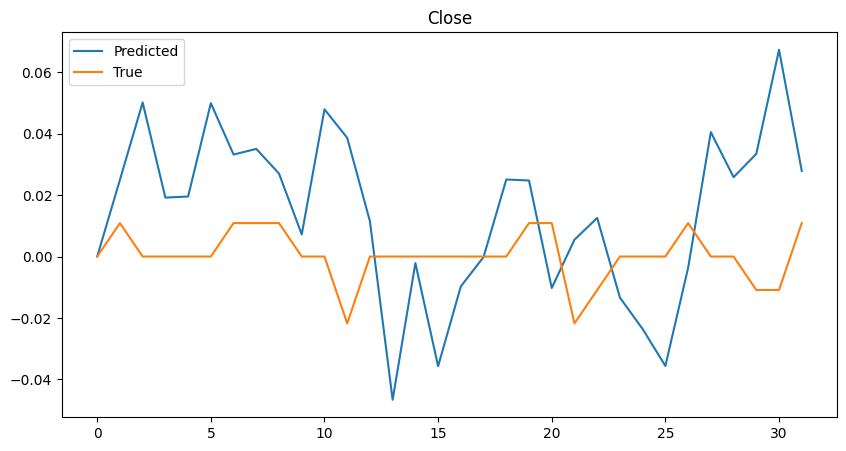

Pred return tensor([[0.0000, 0.0250, 0.0763, 0.0970, 0.1184, 0.1742, 0.2132, 0.2557, 0.2896,
         0.2988, 0.3611, 0.4136, 0.4299, 0.3632, 0.3603, 0.3118, 0.2990, 0.2988,
         0.3314, 0.3643, 0.3504, 0.3578, 0.3748, 0.3564, 0.3244, 0.2773, 0.2726,
         0.3241, 0.3583, 0.4036, 0.4980, 0.5398]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0109,  0.0109,  0.0109,  0.0109,  0.0109,  0.0219,  0.0330,
          0.0442,  0.0442,  0.0442,  0.0215,  0.0215,  0.0215,  0.0215,  0.0215,
          0.0215,  0.0215,  0.0215,  0.0326,  0.0439,  0.0212,  0.0101,  0.0101,
          0.0101,  0.0101,  0.0210,  0.0210,  0.0210,  0.0099, -0.0011,  0.0098]])


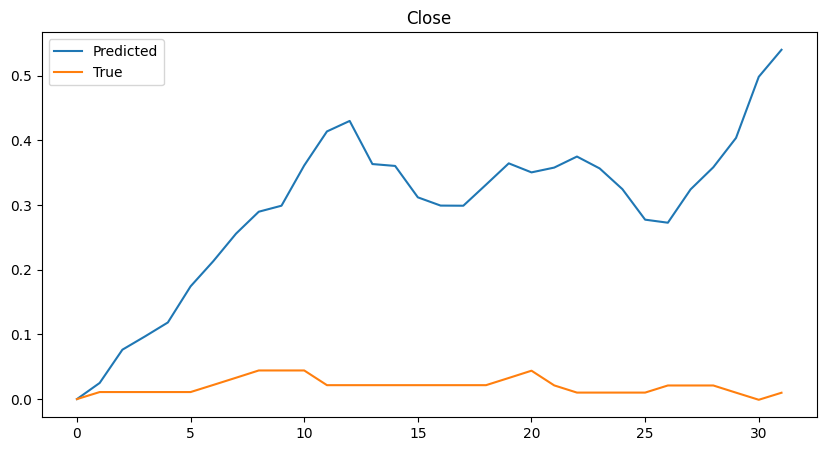

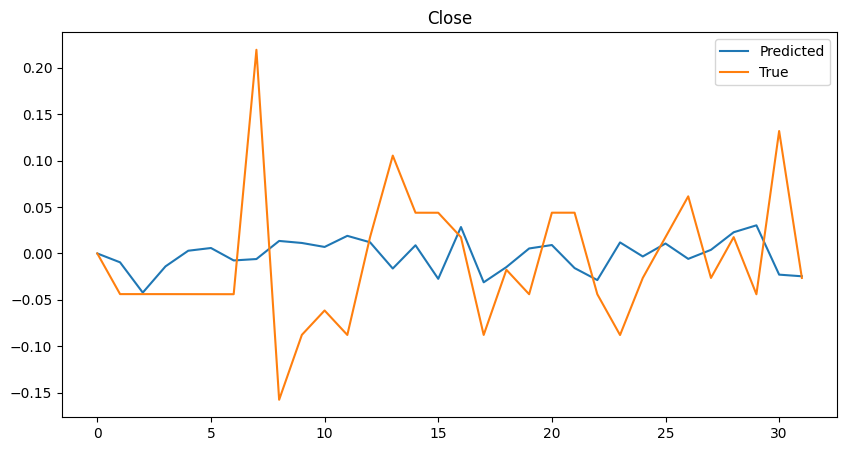

Pred return tensor([[ 0.0000, -0.0095, -0.0513, -0.0645, -0.0617, -0.0562, -0.0633, -0.0689,
         -0.0563, -0.0456, -0.0389, -0.0207, -0.0088, -0.0249, -0.0163, -0.0432,
         -0.0159, -0.0465, -0.0605, -0.0554, -0.0468, -0.0618, -0.0887, -0.0778,
         -0.0808, -0.0709, -0.0763, -0.0727, -0.0515, -0.0227, -0.0450, -0.0685]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0438, -0.0856, -0.1257, -0.1640, -0.2007, -0.2357, -0.0680,
         -0.2149, -0.2837, -0.3277, -0.3868, -0.3760, -0.3102, -0.2799, -0.2483,
         -0.2351, -0.3022, -0.3145, -0.3446, -0.3158, -0.2857, -0.3171, -0.3771,
         -0.3935, -0.3829, -0.3449, -0.3621, -0.3509, -0.3794, -0.2976, -0.3161]])


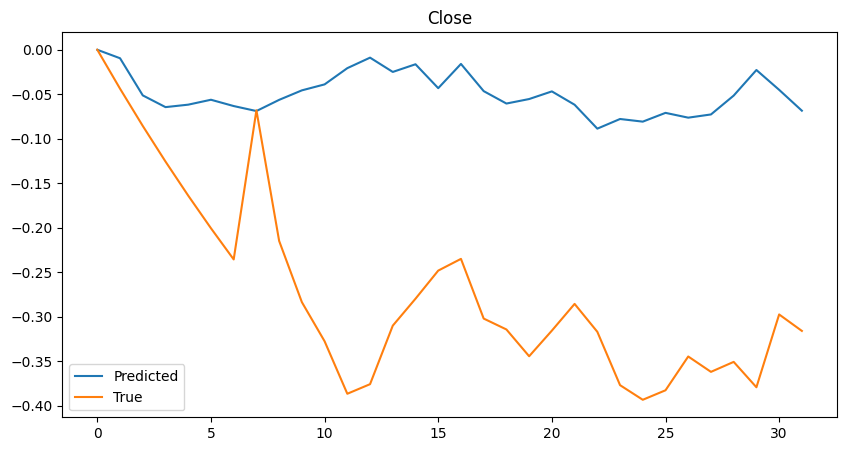

In [10]:
device = torch.device("cpu")
b = 0
for batch in test_dataloader:
    result = inference_decoding(model, batch["encoder_input"], None, config["tgt_len"], device)
    label = batch["label"]
    for i in range(result.shape[0]): 
        plt.figure(figsize=(10, 5))
        plt.plot(result[i, :, 0].detach().numpy(), label = "Predicted")
        plt.plot(label[i, :, 0], label = "True")
        plt.legend()
        plt.title("Close")
        plt.show()
        cumulative_predicted_compound_returns, cumulative_actual_compound_returns = calculate_batch_cumulative_returns(result, label)
        print(f"Pred return {cumulative_predicted_compound_returns}")
        print(f"Actual returns: {cumulative_actual_compound_returns}")
        plt.figure(figsize=(10, 5))
        plt.title("Cum Returns")
        plt.plot(cumulative_predicted_compound_returns.detach().numpy()[0, :], label = "Predicted")
        plt.plot(cumulative_actual_compound_returns[0, :], label = "True")
        plt.legend()
        plt.title("Close")
        plt.show()

    b+=1
    if b == 20:
        break

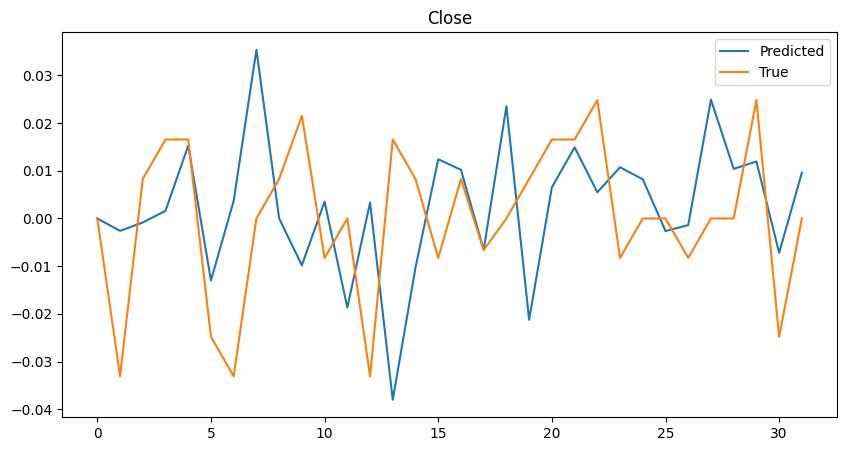

Pred return tensor([[ 0.0000, -0.0026, -0.0034, -0.0018,  0.0134,  0.0002,  0.0039,  0.0394,
          0.0395,  0.0292,  0.0329,  0.0136,  0.0170, -0.0217, -0.0318, -0.0197,
         -0.0097, -0.0162,  0.0069, -0.0145, -0.0081,  0.0067,  0.0123,  0.0231,
          0.0315,  0.0288,  0.0274,  0.0530,  0.0639,  0.0766,  0.0689,  0.0791]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0331, -0.0251, -0.0090,  0.0074, -0.0176, -0.0501, -0.0501,
         -0.0422, -0.0216, -0.0297, -0.0297, -0.0618, -0.0463, -0.0384, -0.0464,
         -0.0385, -0.0448, -0.0448, -0.0369, -0.0210, -0.0048,  0.0199,  0.0115,
          0.0115,  0.0115,  0.0031,  0.0031,  0.0031,  0.0280,  0.0025,  0.0025]])


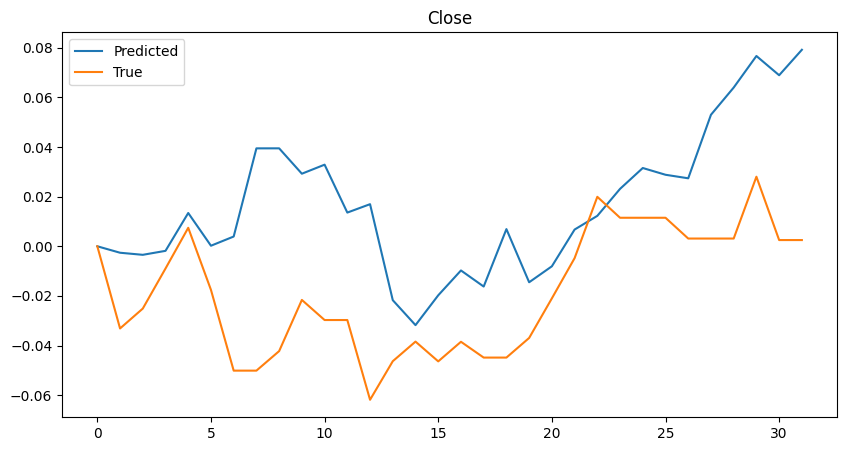

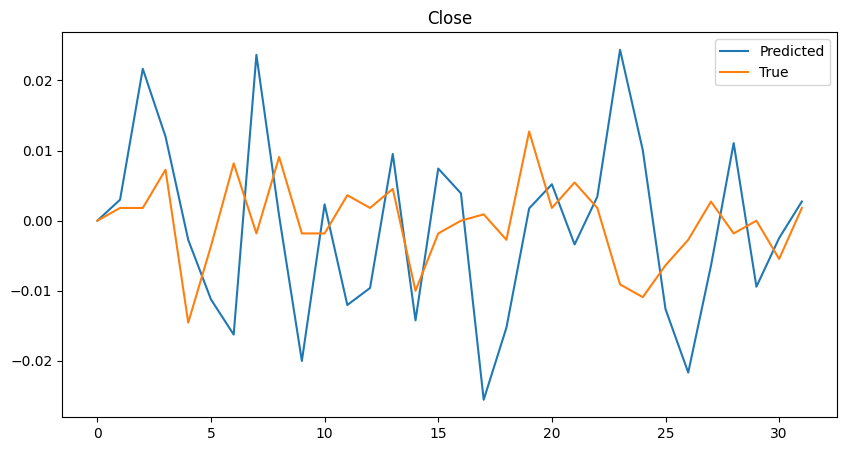

Pred return tensor([[ 0.0000e+00,  2.9932e-03,  2.4724e-02,  3.7030e-02,  3.4188e-02,
          2.2577e-02,  5.9618e-03,  2.9762e-02,  3.0448e-02,  9.8318e-03,
          1.2191e-02,  1.7524e-05, -9.5804e-03, -1.5342e-04, -1.4364e-02,
         -7.0342e-03, -3.1616e-03, -2.8628e-02, -4.3453e-02, -4.1777e-02,
         -3.6796e-02, -4.0059e-02, -3.6768e-02, -1.3282e-02, -3.3504e-03,
         -1.5922e-02, -3.7241e-02, -4.3431e-02, -3.2836e-02, -4.1942e-02,
         -4.4313e-02, -4.1697e-02]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0018,  0.0036,  0.0109, -0.0038, -0.0074,  0.0007, -0.0011,
          0.0080,  0.0062,  0.0043,  0.0080,  0.0098,  0.0144,  0.0043,  0.0024,
          0.0024,  0.0034,  0.0006,  0.0133,  0.0152,  0.0207,  0.0226,  0.0133,
          0.0022, -0.0041, -0.0069, -0.0041, -0.0060, -0.0060, -0.0114, -0.0096]])


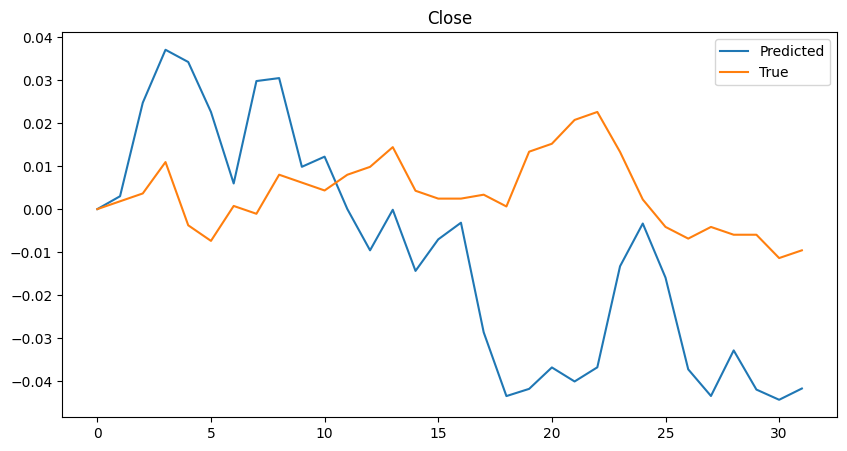

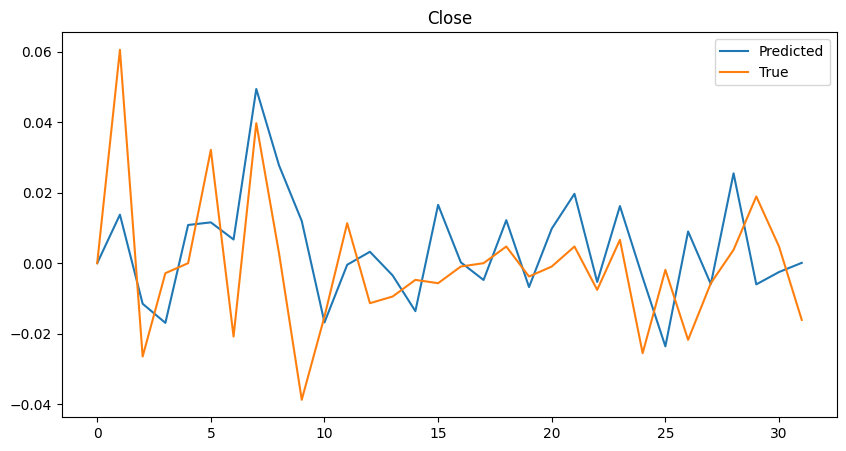

Pred return tensor([[ 0.0000,  0.0138,  0.0021, -0.0149, -0.0042,  0.0073,  0.0141,  0.0643,
          0.0939,  0.1070,  0.0883,  0.0879,  0.0914,  0.0876,  0.0728,  0.0905,
          0.0908,  0.0856,  0.0988,  0.0914,  0.1021,  0.1238,  0.1178,  0.1360,
          0.1313,  0.1046,  0.1146,  0.1079,  0.1362,  0.1294,  0.1265,  0.1266]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0606,  0.0325,  0.0296,  0.0296,  0.0627,  0.0406,  0.0820,
          0.0850,  0.0429,  0.0271,  0.0388,  0.0270,  0.0173,  0.0125,  0.0067,
          0.0058,  0.0058,  0.0105,  0.0067,  0.0057,  0.0105,  0.0029,  0.0095,
         -0.0163, -0.0182, -0.0396, -0.0450, -0.0414, -0.0232, -0.0186, -0.0344]])


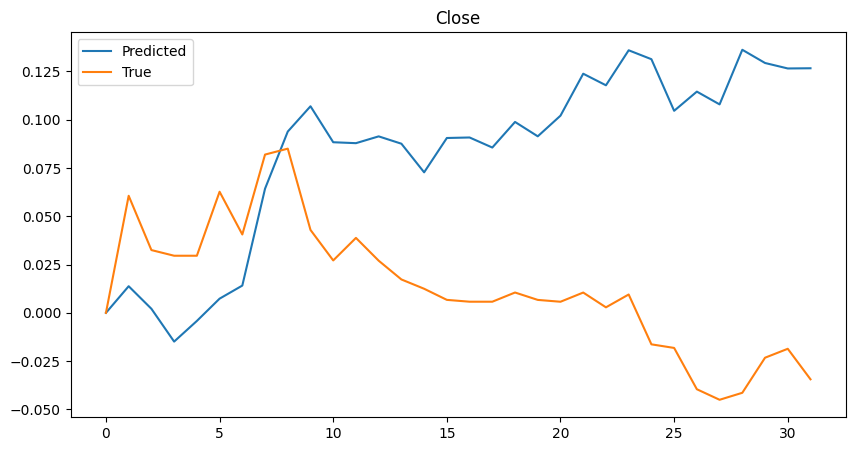

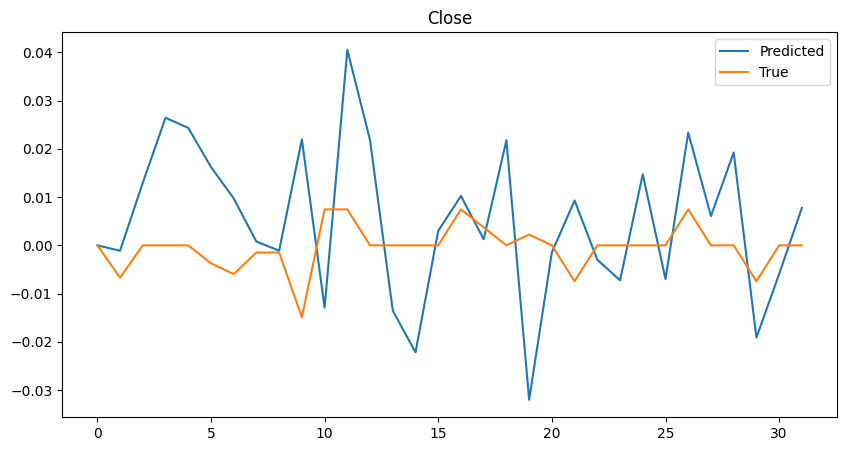

Pred return tensor([[ 0.0000, -0.0011,  0.0118,  0.0386,  0.0639,  0.0812,  0.0917,  0.0925,
          0.0913,  0.1153,  0.1009,  0.1455,  0.1705,  0.1547,  0.1290,  0.1324,
          0.1440,  0.1455,  0.1704,  0.1329,  0.1313,  0.1418,  0.1384,  0.1301,
          0.1468,  0.1387,  0.1653,  0.1724,  0.1950,  0.1721,  0.1652,  0.1742]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0067, -0.0067, -0.0067, -0.0067, -0.0104, -0.0163, -0.0178,
         -0.0192, -0.0338, -0.0266, -0.0194, -0.0194, -0.0194, -0.0194, -0.0194,
         -0.0121, -0.0084, -0.0084, -0.0062, -0.0062, -0.0136, -0.0136, -0.0136,
         -0.0136, -0.0136, -0.0062, -0.0062, -0.0062, -0.0136, -0.0136, -0.0136]])


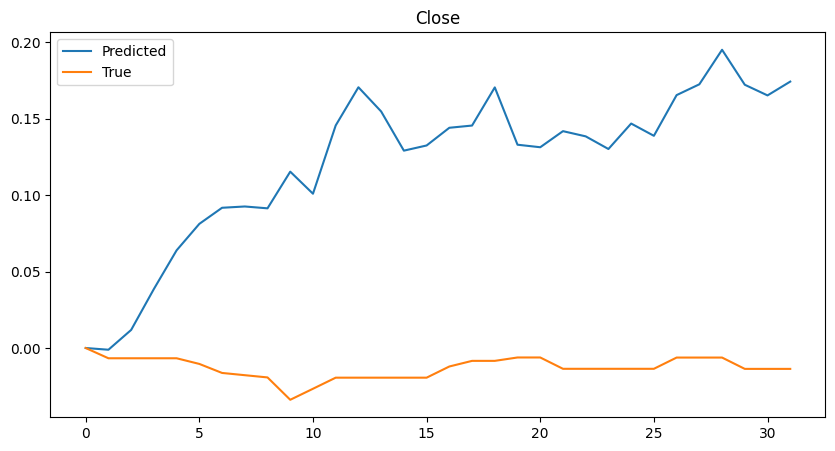

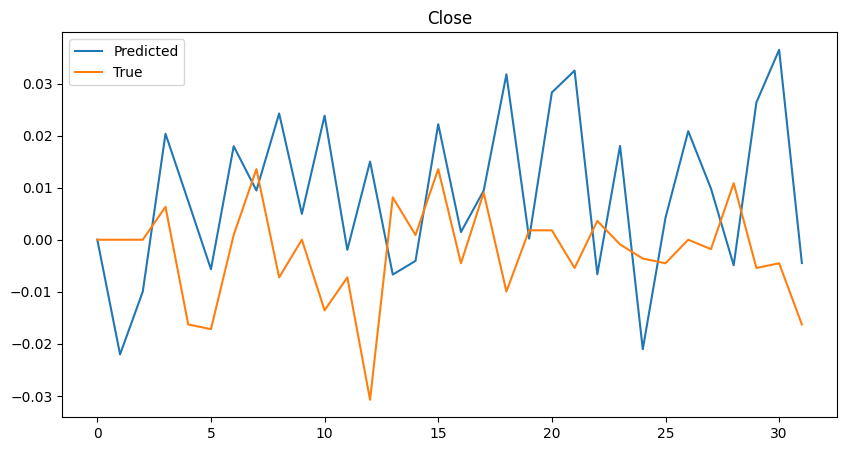

Pred return tensor([[ 0.0000, -0.0220, -0.0318, -0.0121, -0.0048, -0.0104,  0.0074,  0.0169,
          0.0415,  0.0467,  0.0716,  0.0696,  0.0856,  0.0784,  0.0740,  0.0978,
          0.0994,  0.1098,  0.1450,  0.1453,  0.1777,  0.2159,  0.2078,  0.2296,
          0.2038,  0.2089,  0.2341,  0.2462,  0.2401,  0.2728,  0.3192,  0.3133]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0000,  0.0000,  0.0063, -0.0100, -0.0270, -0.0262, -0.0130,
         -0.0201, -0.0201, -0.0334, -0.0404, -0.0699, -0.0623, -0.0614, -0.0487,
         -0.0530, -0.0445, -0.0540, -0.0522, -0.0505, -0.0557, -0.0523, -0.0531,
         -0.0565, -0.0608, -0.0608, -0.0625, -0.0523, -0.0575, -0.0617, -0.0770]])


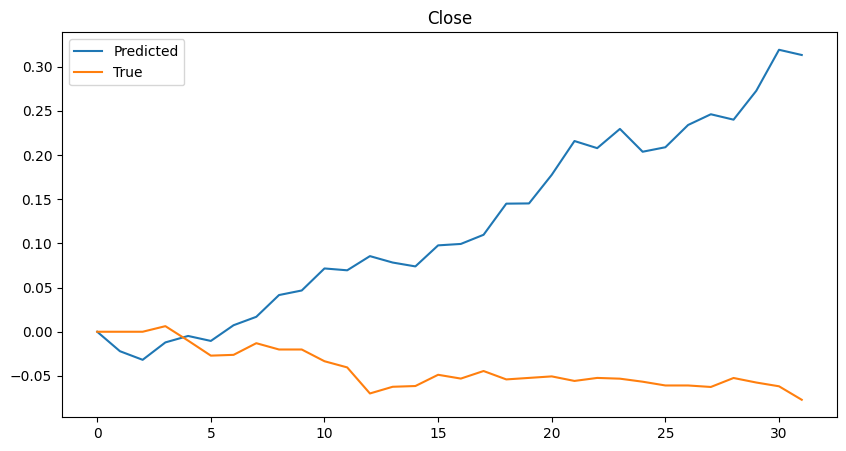

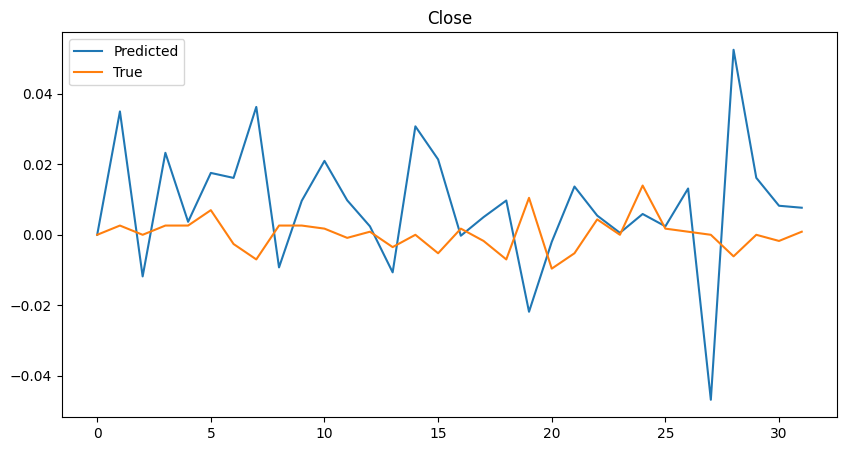

Pred return tensor([[0.0000, 0.0350, 0.0228, 0.0465, 0.0504, 0.0688, 0.0860, 0.1254, 0.1150,
         0.1257, 0.1493, 0.1605, 0.1633, 0.1509, 0.1863, 0.2117, 0.2114, 0.2174,
         0.2292, 0.2024, 0.2000, 0.2164, 0.2230, 0.2237, 0.2309, 0.2339, 0.2501,
         0.1916, 0.2541, 0.2744, 0.2848, 0.2947]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0026,  0.0026,  0.0052,  0.0079,  0.0149,  0.0123,  0.0052,
          0.0078,  0.0105,  0.0122,  0.0113,  0.0122,  0.0087,  0.0087,  0.0034,
          0.0052,  0.0034, -0.0036,  0.0068, -0.0028, -0.0081, -0.0037, -0.0037,
          0.0102,  0.0119,  0.0128,  0.0128,  0.0066,  0.0066,  0.0049,  0.0058]])


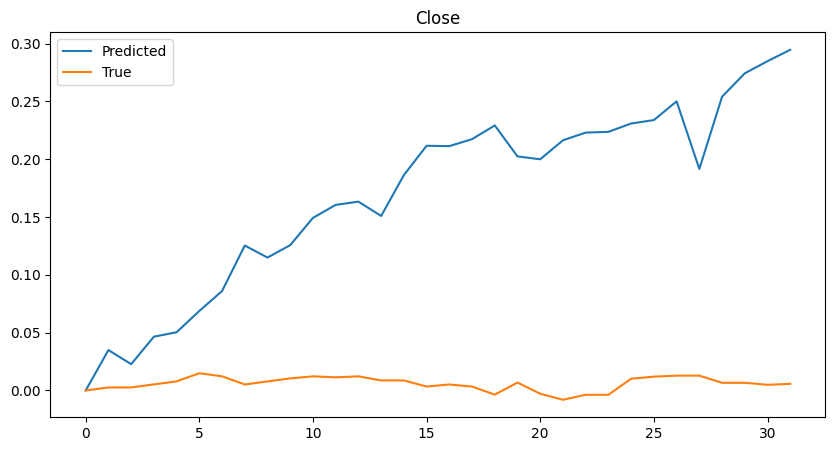

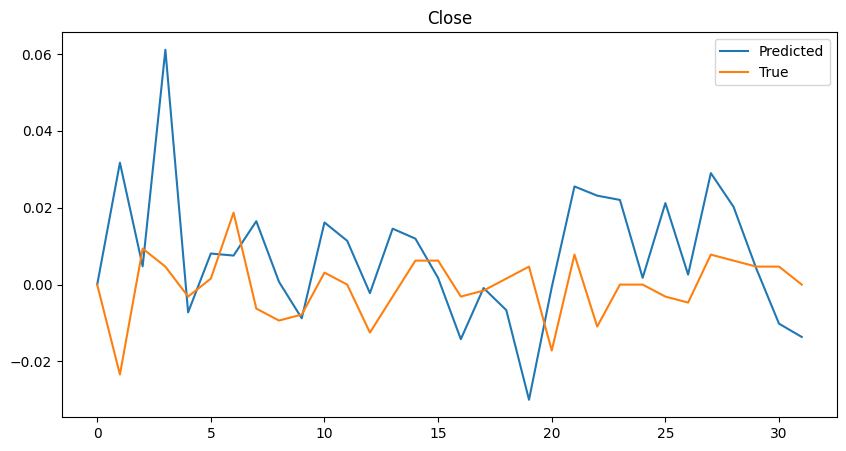

Pred return tensor([[0.0000, 0.0317, 0.0366, 0.1000, 0.0921, 0.1009, 0.1092, 0.1275, 0.1283,
         0.1184, 0.1365, 0.1495, 0.1469, 0.1636, 0.1775, 0.1796, 0.1628, 0.1617,
         0.1540, 0.1194, 0.1186, 0.1472, 0.1738, 0.1997, 0.2018, 0.2273, 0.2305,
         0.2662, 0.2918, 0.2972, 0.2840, 0.2665]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0234, -0.0143, -0.0096, -0.0127, -0.0112,  0.0073,  0.0010,
         -0.0083, -0.0161, -0.0130, -0.0130, -0.0253, -0.0284, -0.0223, -0.0162,
         -0.0193, -0.0208, -0.0193, -0.0147, -0.0316, -0.0240, -0.0347, -0.0347,
         -0.0347, -0.0377, -0.0422, -0.0347, -0.0287, -0.0242, -0.0196, -0.0196]])


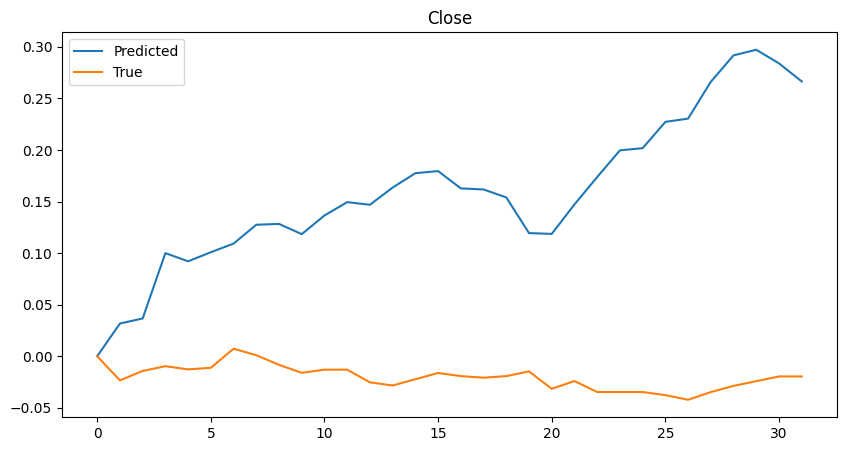

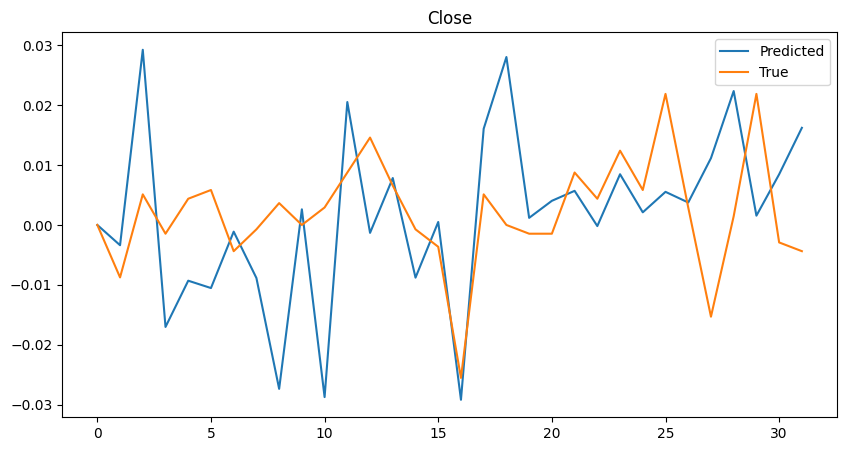

Pred return tensor([[ 0.0000, -0.0034,  0.0258,  0.0083, -0.0011, -0.0116, -0.0127, -0.0214,
         -0.0482, -0.0457, -0.0731, -0.0541, -0.0554, -0.0480, -0.0563, -0.0559,
         -0.0834, -0.0687, -0.0426, -0.0414, -0.0376, -0.0321, -0.0323, -0.0241,
         -0.0220, -0.0166, -0.0129, -0.0019,  0.0204,  0.0220,  0.0306,  0.0473]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000e+00, -8.7510e-03, -3.6904e-03, -5.1435e-03, -7.9024e-04,
          5.0395e-03,  6.4182e-04, -8.7857e-05,  3.5582e-03,  3.5582e-03,
          6.4856e-03,  1.5293e-02,  3.0100e-02,  3.6859e-02,  3.6103e-02,
          3.2326e-02,  5.9826e-03,  1.1118e-02,  1.1118e-02,  9.6436e-03,
          8.1710e-03,  1.6994e-02,  2.1444e-02,  3.4106e-02,  4.0138e-02,
          6.2888e-02,  6.5987e-02,  4.9671e-02,  5.1201e-02,  7.4189e-02,
          7.1058e-02,  6.6374e-02]])


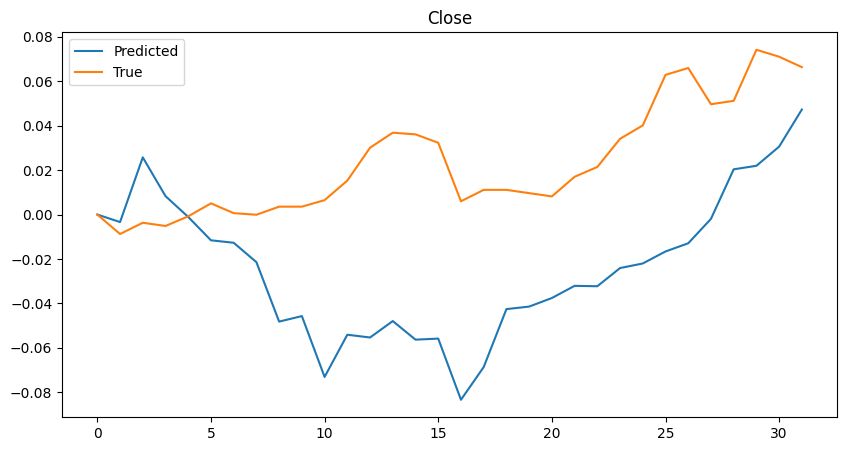

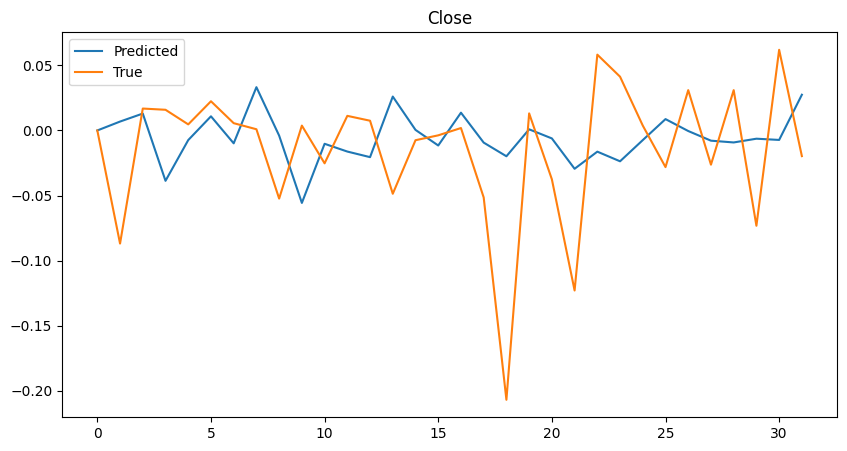

Pred return tensor([[ 0.0000,  0.0068,  0.0199, -0.0195, -0.0268, -0.0162, -0.0259,  0.0065,
          0.0025, -0.0533, -0.0630, -0.0782, -0.0971, -0.0736, -0.0732, -0.0839,
         -0.0714, -0.0800, -0.0983, -0.0975, -0.1030, -0.1294, -0.1436, -0.1639,
         -0.1701, -0.1628, -0.1632, -0.1698, -0.1774, -0.1826, -0.1886, -0.1663]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0869, -0.0715, -0.0568, -0.0524, -0.0311, -0.0257, -0.0248,
         -0.0758, -0.0724, -0.0958, -0.0856, -0.0788, -0.1236, -0.1302, -0.1334,
         -0.1318, -0.1765, -0.3469, -0.3383, -0.3632, -0.4415, -0.4089, -0.3845,
         -0.3822, -0.3996, -0.3810, -0.3973, -0.3786, -0.4241, -0.3884, -0.4004]])


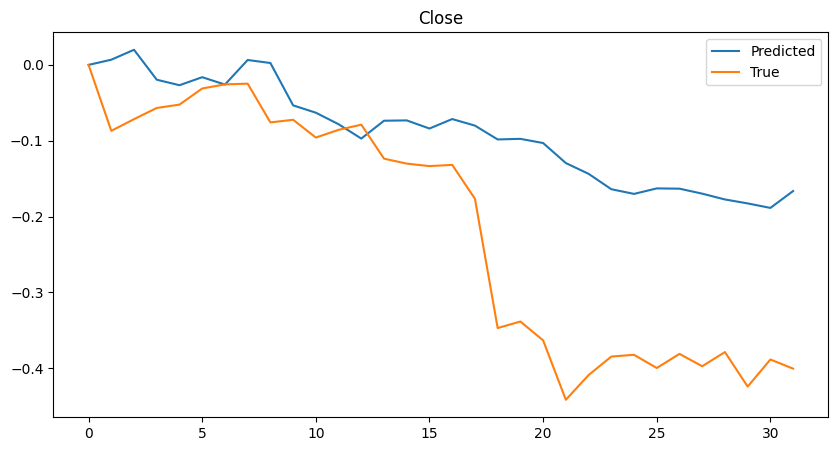

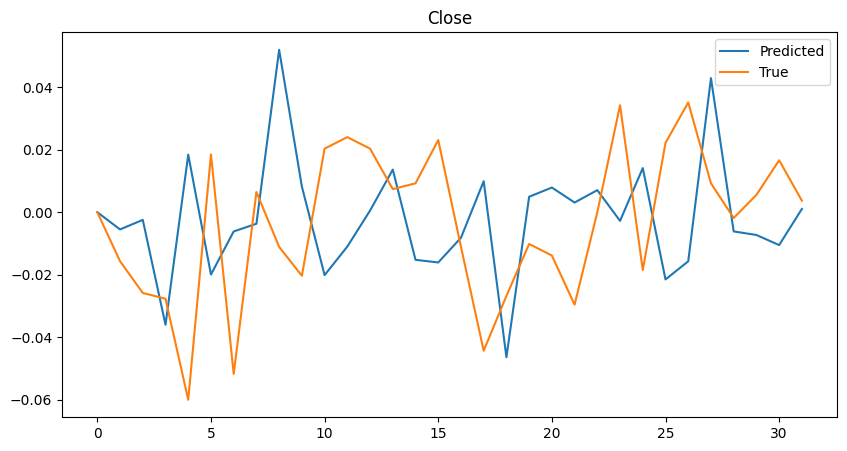

Pred return tensor([[ 0.0000, -0.0055, -0.0079, -0.0436, -0.0260, -0.0455, -0.0513, -0.0548,
         -0.0057,  0.0024, -0.0178, -0.0286, -0.0281, -0.0148, -0.0298, -0.0454,
         -0.0532, -0.0438, -0.0882, -0.0837, -0.0765, -0.0736, -0.0671, -0.0697,
         -0.0565, -0.0768, -0.0913, -0.0523, -0.0582, -0.0650, -0.0748, -0.0739]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0157, -0.0411, -0.0676, -0.1235, -0.1074, -0.1535, -0.1480,
         -0.1575, -0.1746, -0.1578, -0.1376, -0.1201, -0.1136, -0.1054, -0.0848,
         -0.0949, -0.1350, -0.1581, -0.1667, -0.1782, -0.2025, -0.2025, -0.1753,
         -0.1905, -0.1726, -0.1435, -0.1356, -0.1372, -0.1324, -0.1180, -0.1148]])


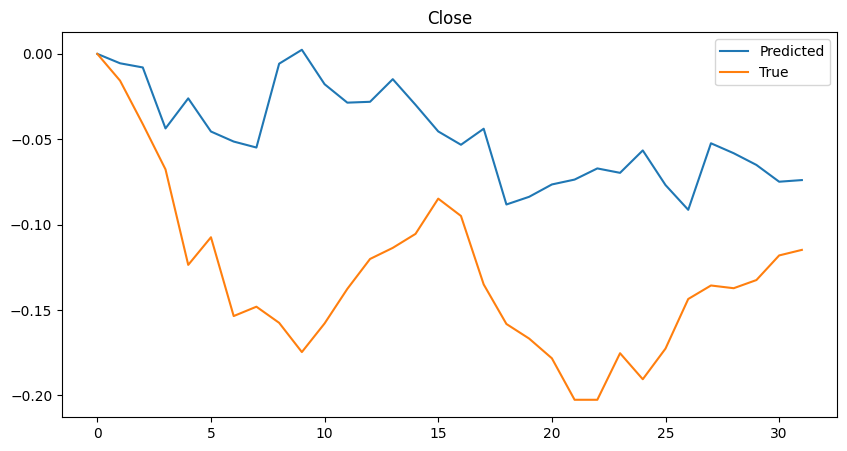

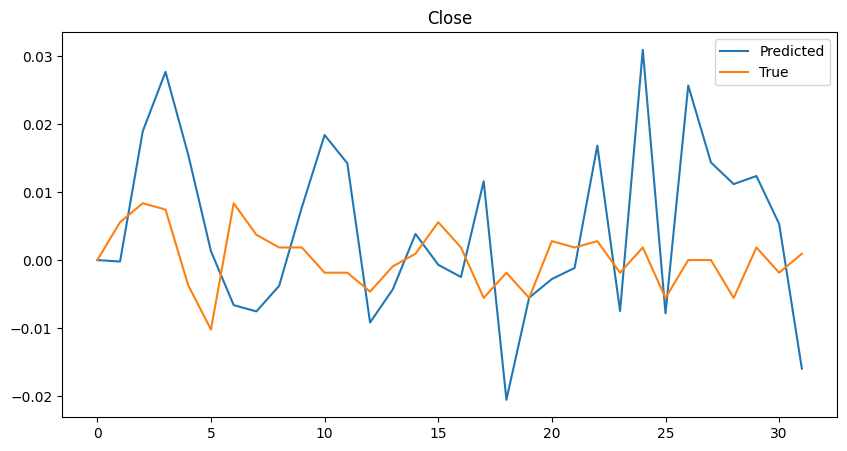

Pred return tensor([[ 0.0000, -0.0002,  0.0187,  0.0469,  0.0631,  0.0645,  0.0575,  0.0495,
          0.0455,  0.0536,  0.0730,  0.0883,  0.0783,  0.0736,  0.0778,  0.0770,
          0.0743,  0.0868,  0.0645,  0.0586,  0.0556,  0.0544,  0.0721,  0.0641,
          0.0970,  0.0884,  0.1164,  0.1324,  0.1450,  0.1592,  0.1653,  0.1467]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[0.0000, 0.0056, 0.0140, 0.0215, 0.0177, 0.0073, 0.0157, 0.0195, 0.0214,
         0.0233, 0.0214, 0.0195, 0.0148, 0.0138, 0.0148, 0.0204, 0.0223, 0.0166,
         0.0147, 0.0091, 0.0119, 0.0138, 0.0166, 0.0147, 0.0166, 0.0109, 0.0109,
         0.0109, 0.0053, 0.0072, 0.0053, 0.0062]])


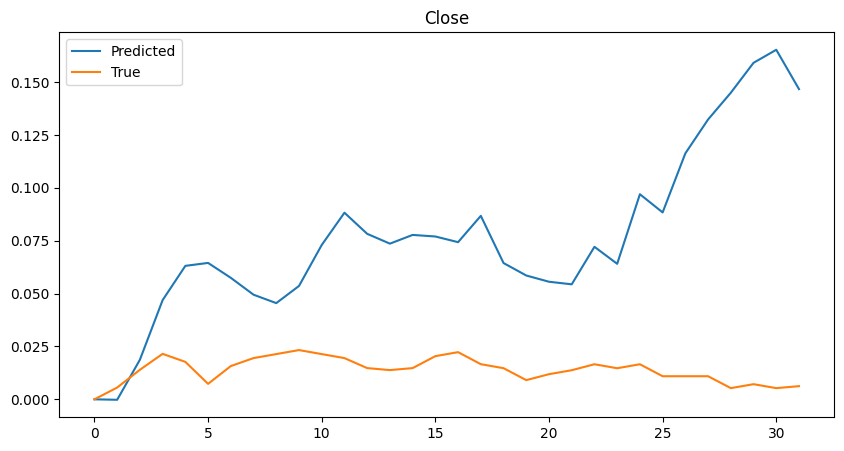

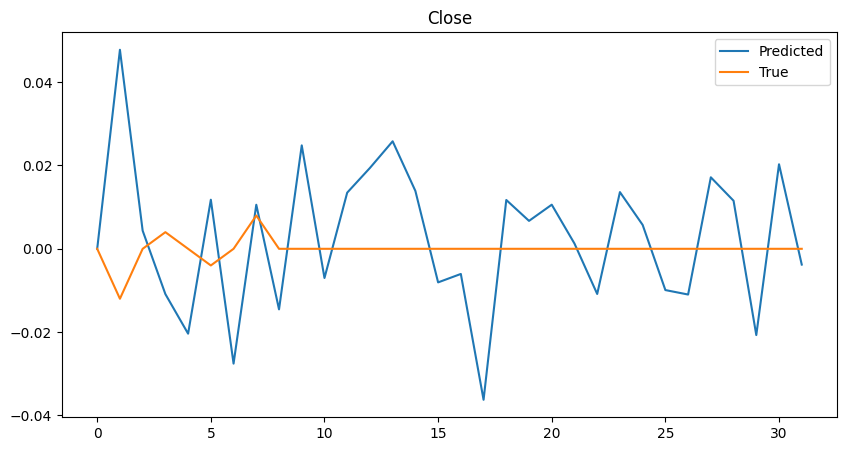

Pred return tensor([[ 0.0000,  0.0478,  0.0523,  0.0409,  0.0197,  0.0317,  0.0033,  0.0139,
         -0.0009,  0.0240,  0.0168,  0.0305,  0.0505,  0.0776,  0.0926,  0.0838,
          0.0772,  0.0382,  0.0504,  0.0574,  0.0686,  0.0699,  0.0583,  0.0727,
          0.0789,  0.0682,  0.0565,  0.0746,  0.0870,  0.0645,  0.0861,  0.0820]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0120, -0.0120, -0.0080, -0.0080, -0.0120, -0.0120, -0.0041,
         -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041,
         -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041,
         -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041, -0.0041]])


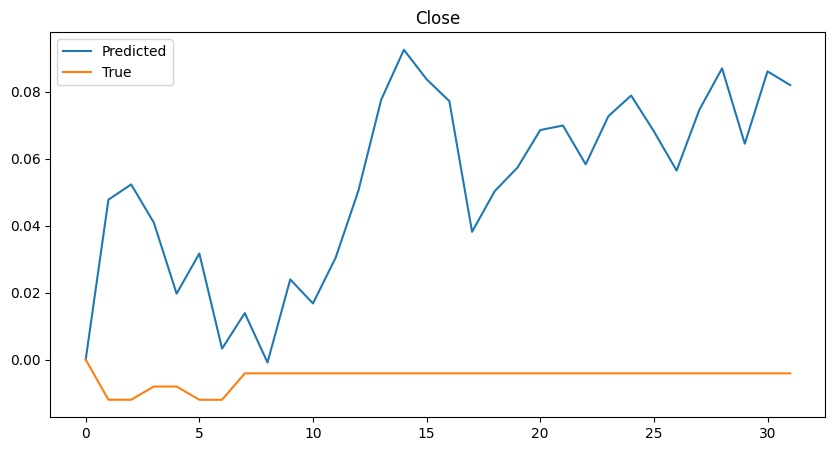

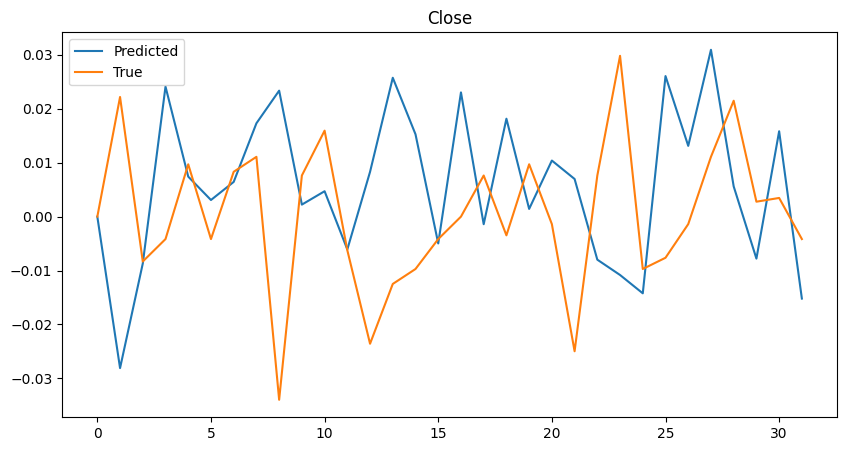

Pred return tensor([[ 0.0000, -0.0281, -0.0365, -0.0133, -0.0060, -0.0029,  0.0035,  0.0209,
          0.0447,  0.0470,  0.0520,  0.0456,  0.0543,  0.0814,  0.0979,  0.0925,
          0.1176,  0.1161,  0.1363,  0.1380,  0.1498,  0.1578,  0.1486,  0.1362,
          0.1200,  0.1492,  0.1643,  0.2003,  0.2070,  0.1976,  0.2166,  0.1981]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0222,  0.0137,  0.0095,  0.0193,  0.0150,  0.0235,  0.0348,
         -0.0003,  0.0073,  0.0234,  0.0170, -0.0070, -0.0194, -0.0289, -0.0329,
         -0.0329, -0.0256, -0.0289, -0.0195, -0.0209, -0.0453, -0.0380, -0.0094,
         -0.0190, -0.0264, -0.0278, -0.0170,  0.0041,  0.0069,  0.0104,  0.0062]])


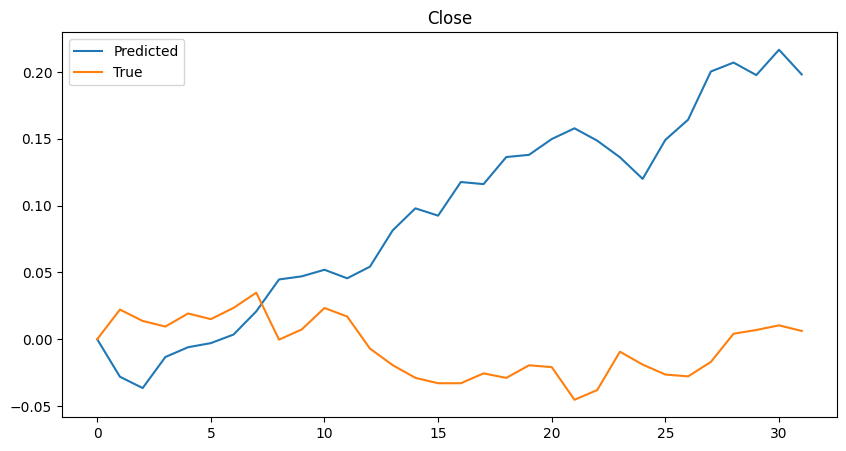

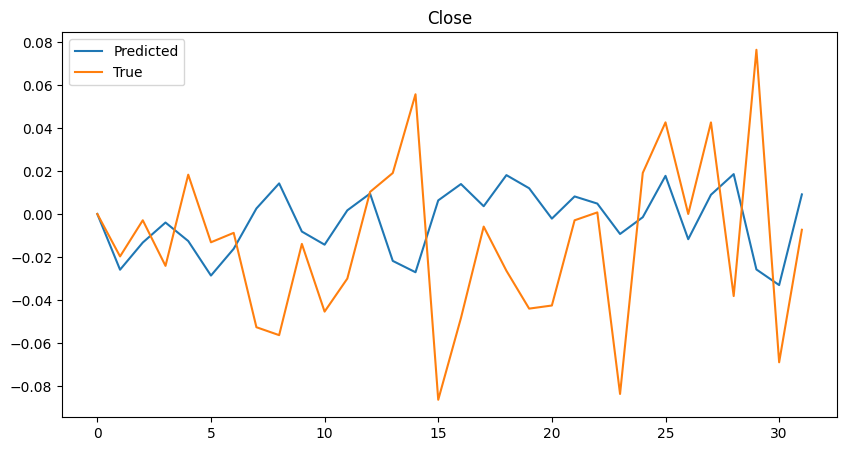

Pred return tensor([[ 0.0000, -0.0259, -0.0389, -0.0427, -0.0547, -0.0818, -0.0967, -0.0943,
         -0.0815, -0.0890, -0.1020, -0.1004, -0.0919, -0.1117, -0.1358, -0.1303,
         -0.1182, -0.1150, -0.0990, -0.0882, -0.0902, -0.0828, -0.0784, -0.0869,
         -0.0883, -0.0721, -0.0830, -0.0748, -0.0576, -0.0819, -0.1123, -0.1042]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0197, -0.0226, -0.0462, -0.0287, -0.0415, -0.0499, -0.1000,
         -0.1507, -0.1625, -0.2005, -0.2245, -0.2166, -0.2017, -0.1572, -0.2300,
         -0.2673, -0.2716, -0.2908, -0.3220, -0.3509, -0.3528, -0.3523, -0.4065,
         -0.3952, -0.3694, -0.3694, -0.3425, -0.3676, -0.3194, -0.3663, -0.3710]])


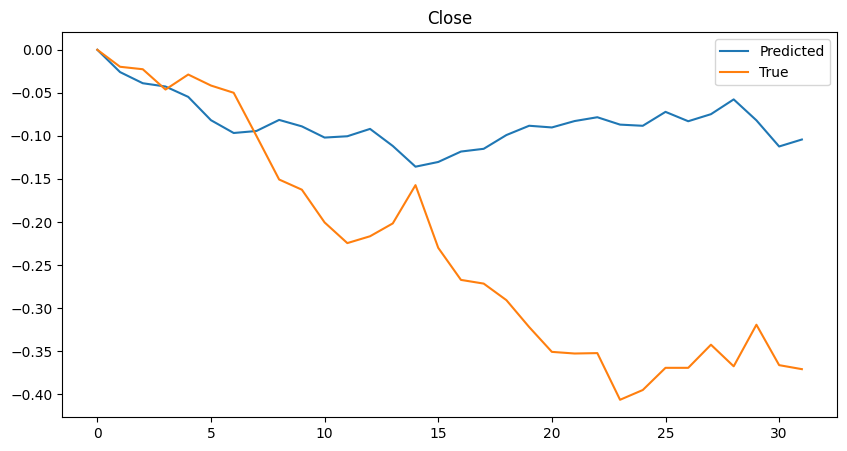

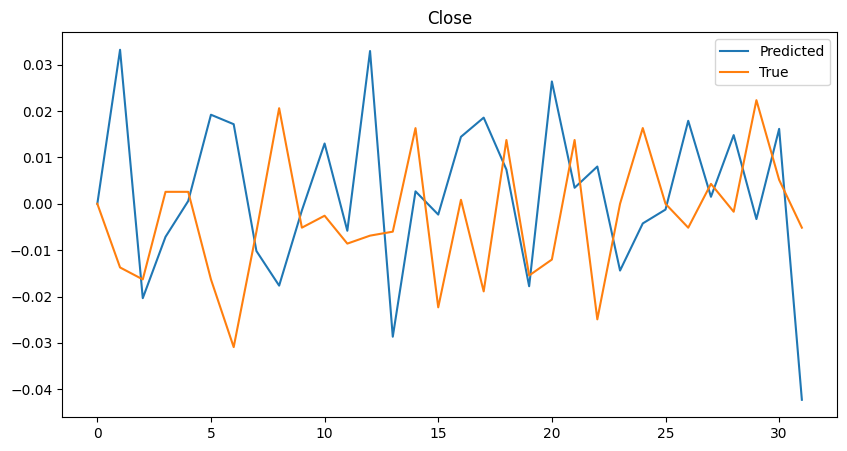

Pred return tensor([[0.0000, 0.0332, 0.0122, 0.0050, 0.0056, 0.0249, 0.0425, 0.0318, 0.0136,
         0.0122, 0.0253, 0.0193, 0.0529, 0.0227, 0.0255, 0.0231, 0.0379, 0.0571,
         0.0649, 0.0460, 0.0736, 0.0773, 0.0859, 0.0703, 0.0658, 0.0644, 0.0835,
         0.0851, 0.1012, 0.0975, 0.1153, 0.0681]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0137, -0.0298, -0.0273, -0.0248, -0.0407, -0.0704, -0.0759,
         -0.0569, -0.0618, -0.0642, -0.0722, -0.0786, -0.0841, -0.0692, -0.0900,
         -0.0892, -0.1064, -0.0941, -0.1081, -0.1188, -0.1067, -0.1290, -0.1290,
         -0.1148, -0.1148, -0.1193, -0.1155, -0.1171, -0.0973, -0.0927, -0.0974]])


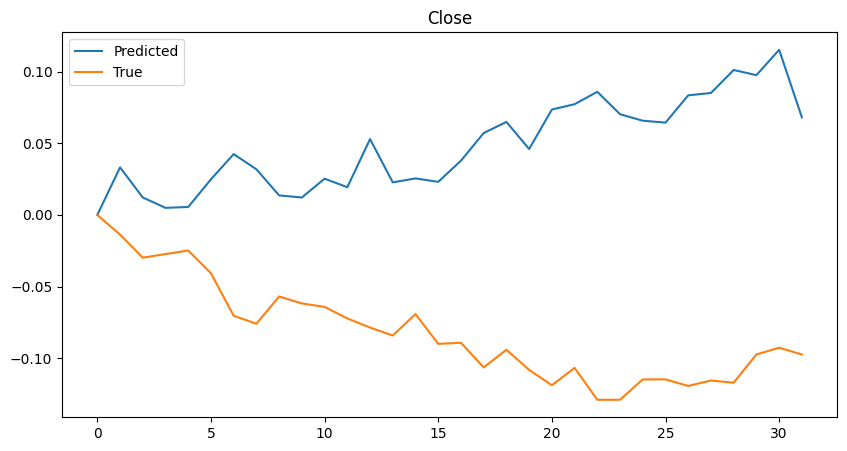

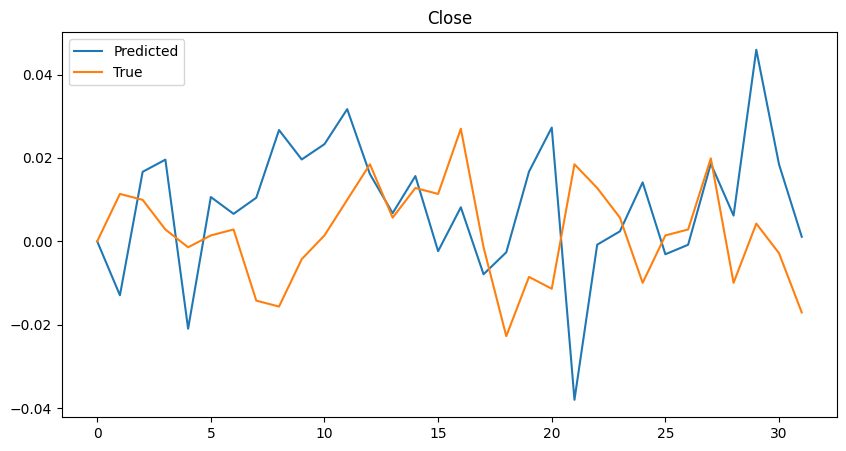

Pred return tensor([[ 0.0000, -0.0129,  0.0035,  0.0232,  0.0018,  0.0124,  0.0191,  0.0297,
          0.0572,  0.0780,  0.1031,  0.1381,  0.1564,  0.1642,  0.1824,  0.1797,
          0.1893,  0.1799,  0.1768,  0.1965,  0.2291,  0.1825,  0.1815,  0.1843,
          0.2011,  0.1974,  0.1964,  0.2187,  0.2262,  0.2825,  0.3062,  0.3076]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0114,  0.0214,  0.0243,  0.0229,  0.0243,  0.0273,  0.0127,
         -0.0032, -0.0074, -0.0060,  0.0039,  0.0224,  0.0282,  0.0414,  0.0532,
          0.0817,  0.0801,  0.0556,  0.0466,  0.0347,  0.0538,  0.0673,  0.0733,
          0.0627,  0.0642,  0.0672,  0.0884,  0.0776,  0.0822,  0.0791,  0.0607]])


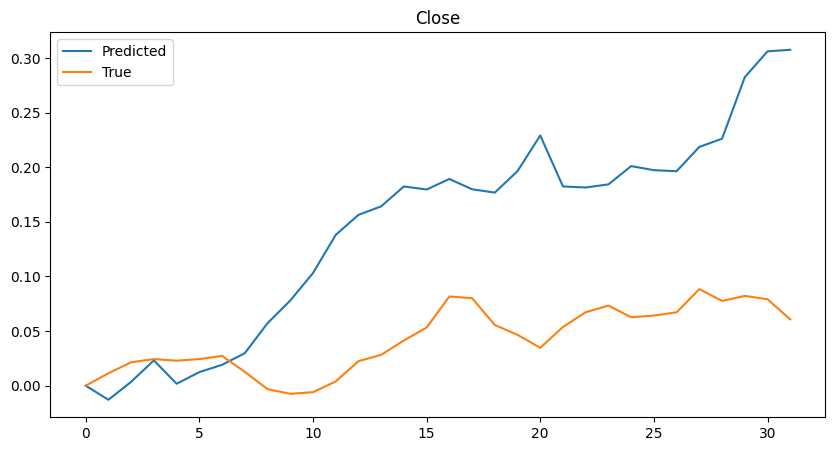

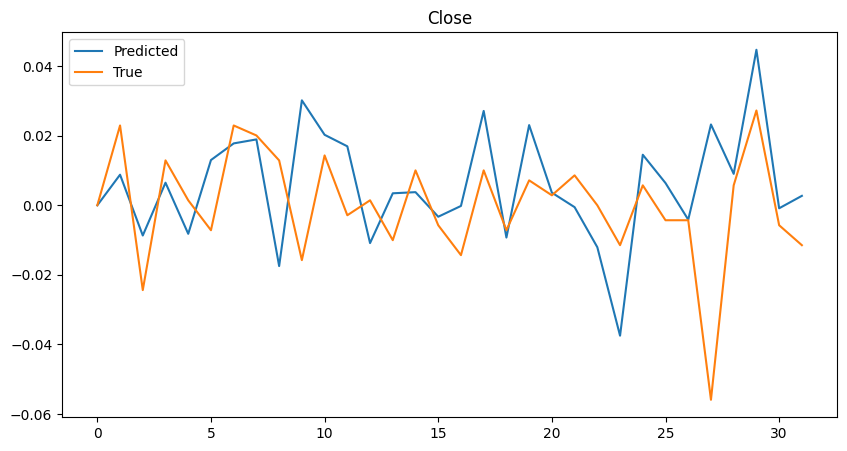

Pred return tensor([[ 0.0000e+00,  8.7923e-03,  2.9087e-05,  6.5212e-03, -1.7316e-03,
          1.1249e-02,  2.9236e-02,  4.8724e-02,  3.0402e-02,  6.1487e-02,
          8.2994e-02,  1.0135e-01,  8.9384e-02,  9.3136e-02,  9.7261e-02,
          9.3649e-02,  9.3442e-02,  1.2310e-01,  1.1268e-01,  1.3833e-01,
          1.4246e-01,  1.4184e-01,  1.2808e-01,  8.5791e-02,  1.0157e-01,
          1.0861e-01,  1.0404e-01,  1.2968e-01,  1.3989e-01,  1.9084e-01,
          1.8982e-01,  1.9304e-01]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0229, -0.0020,  0.0109,  0.0123,  0.0051,  0.0281,  0.0488,
          0.0623,  0.0456,  0.0606,  0.0575,  0.0590,  0.0484,  0.0589,  0.0529,
          0.0378,  0.0482,  0.0407,  0.0481,  0.0511,  0.0602,  0.0602,  0.0480,
          0.0540,  0.0495,  0.0450, -0.0134, -0.0078,  0.0192,  0.0134,  0.0018]])


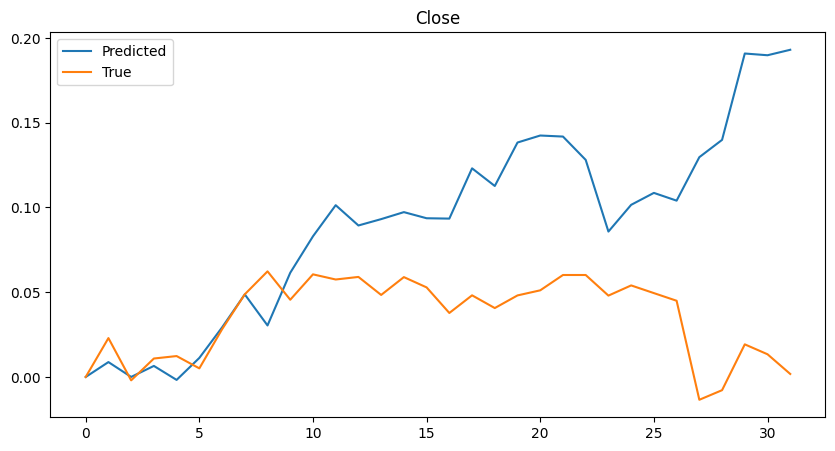

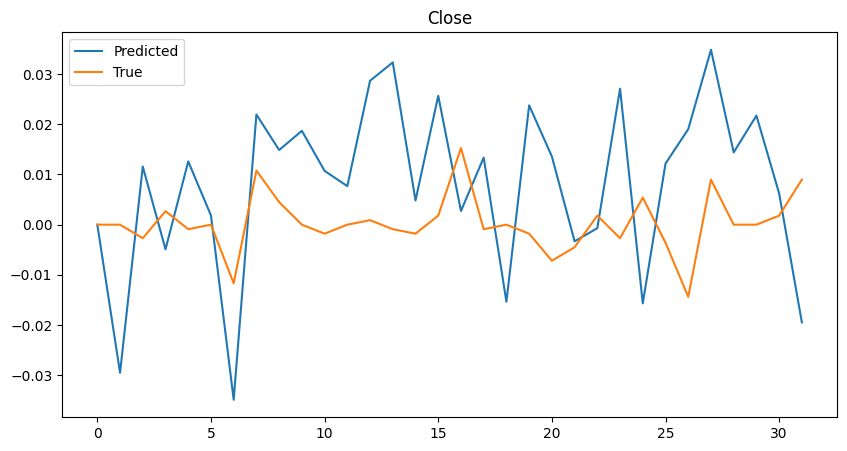

Pred return tensor([[ 0.0000, -0.0295, -0.0183, -0.0231, -0.0108, -0.0090, -0.0435, -0.0225,
         -0.0080,  0.0105,  0.0214,  0.0292,  0.0587,  0.0929,  0.0981,  0.1263,
          0.1294,  0.1445,  0.1269,  0.1537,  0.1694,  0.1655,  0.1647,  0.1962,
          0.1775,  0.1918,  0.2144,  0.2567,  0.2748,  0.3025,  0.3106,  0.2851]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000e+00,  0.0000e+00, -2.6930e-03, -7.0930e-06, -9.0480e-04,
         -9.0480e-04, -1.2564e-02, -1.9258e-03,  2.5544e-03,  2.5544e-03,
          7.5436e-04,  7.5436e-04,  1.6528e-03,  7.5352e-04, -1.0433e-03,
          7.5042e-04,  1.6024e-02,  1.5112e-02,  1.5112e-02,  1.3290e-02,
          6.0138e-03,  1.4987e-03,  3.2967e-03,  5.9497e-04,  5.9844e-03,
          2.3725e-03, -1.2024e-02, -3.1541e-03, -3.1541e-03, -3.1541e-03,
         -1.3644e-03,  7.5998e-03]])


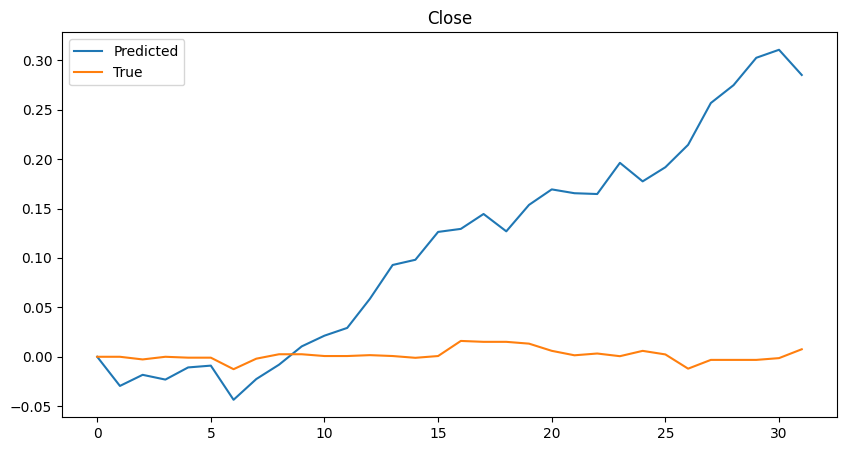

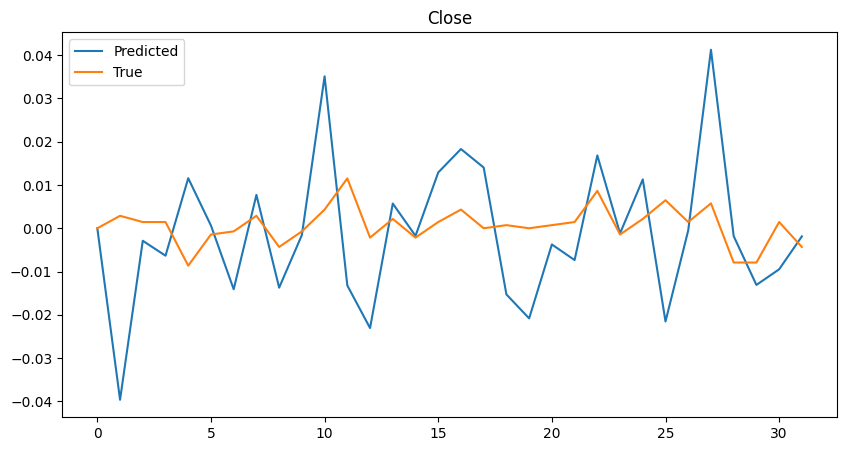

Pred return tensor([[ 0.0000, -0.0396, -0.0424, -0.0485, -0.0375, -0.0369, -0.0504, -0.0431,
         -0.0563, -0.0577, -0.0247, -0.0376, -0.0597, -0.0544, -0.0560, -0.0439,
         -0.0264, -0.0127, -0.0278, -0.0480, -0.0516, -0.0586, -0.0427, -0.0438,
         -0.0330, -0.0539, -0.0543, -0.0153, -0.0171, -0.0300, -0.0392, -0.0410]],
       grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000,  0.0029,  0.0043,  0.0058, -0.0029, -0.0044, -0.0051, -0.0022,
         -0.0065, -0.0072, -0.0029,  0.0085,  0.0064,  0.0085,  0.0064,  0.0078,
          0.0122,  0.0122,  0.0129,  0.0129,  0.0136,  0.0151,  0.0238,  0.0224,
          0.0246,  0.0312,  0.0327,  0.0387,  0.0304,  0.0223,  0.0237,  0.0193]])


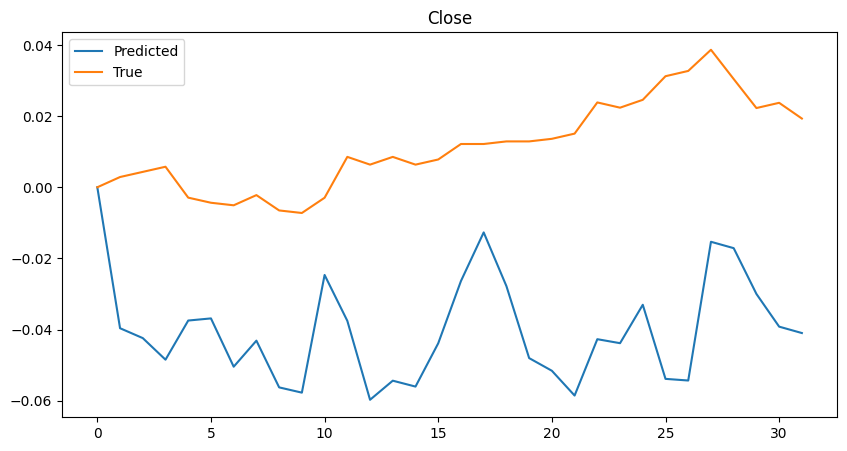

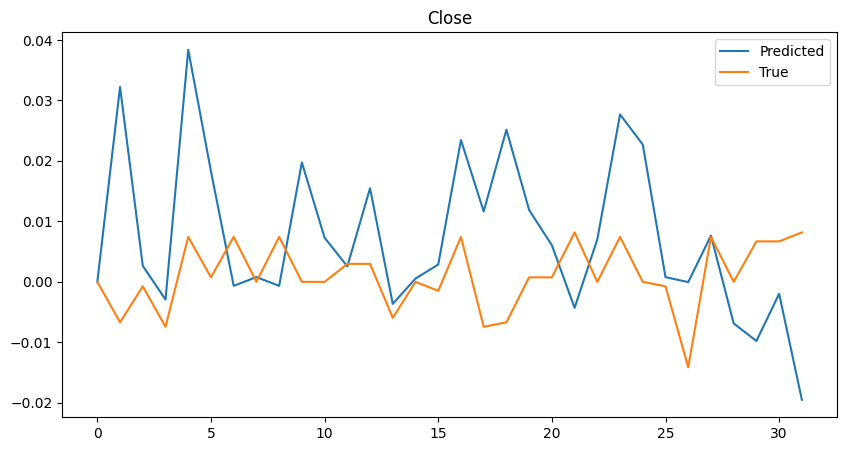

Pred return tensor([[0.0000, 0.0322, 0.0350, 0.0319, 0.0715, 0.0911, 0.0904, 0.0913, 0.0906,
         0.1121, 0.1202, 0.1231, 0.1405, 0.1363, 0.1369, 0.1402, 0.1669, 0.1805,
         0.2102, 0.2246, 0.2320, 0.2267, 0.2353, 0.2695, 0.2984, 0.2994, 0.2993,
         0.3093, 0.3003, 0.2875, 0.2850, 0.2599]], grad_fn=<SubBackward0>)
Actual returns: tensor([[ 0.0000, -0.0067, -0.0074, -0.0148, -0.0075, -0.0067,  0.0006,  0.0006,
          0.0081,  0.0081,  0.0081,  0.0111,  0.0141,  0.0081,  0.0081,  0.0066,
          0.0140,  0.0065, -0.0002,  0.0005,  0.0013,  0.0094,  0.0094,  0.0169,
          0.0169,  0.0162,  0.0018,  0.0093,  0.0093,  0.0160,  0.0228,  0.0312]])


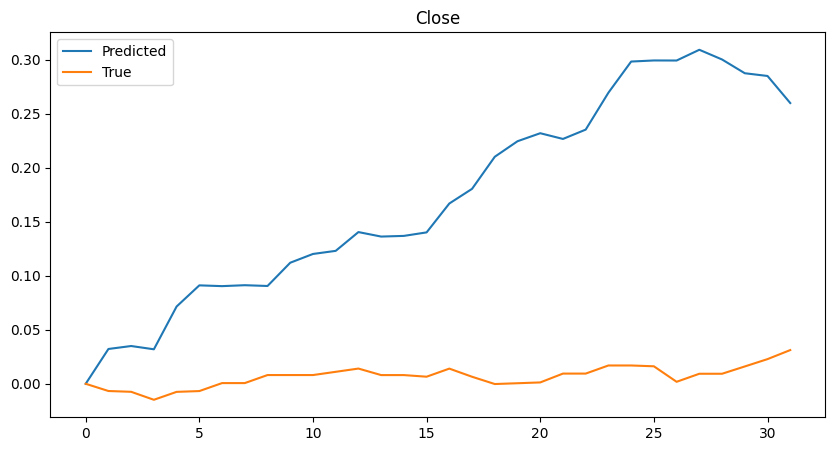

In [33]:
device = torch.device("cpu")
b = 0
for batch in test_dataloader:
    result = inference_decoding(model, batch["encoder_input"], None, config["tgt_len"], device)
    label = batch["label"]
    for i in range(result.shape[0]): 
        plt.figure(figsize=(10, 5))
        plt.plot(result[i, :, 0].detach().numpy(), label = "Predicted")
        plt.plot(label[i, :, 0], label = "True")
        plt.legend()
        plt.title("Close")
        plt.show()
        cumulative_predicted_compound_returns, cumulative_actual_compound_returns = calculate_batch_cumulative_returns(result, label)
        print(f"Pred return {cumulative_predicted_compound_returns}")
        print(f"Actual returns: {cumulative_actual_compound_returns}")
        plt.figure(figsize=(10, 5))
        plt.title("Cum Returns")
        plt.plot(cumulative_predicted_compound_returns.detach().numpy()[0, :], label = "Predicted")
        plt.plot(cumulative_actual_compound_returns[0, :], label = "True")
        plt.legend()
        plt.title("Close")
        plt.show()

    b+=1
    if b == 20:
        break

In [40]:
result[:, 0]

tensor([ 0.0000, -0.0139, -0.0169, -0.0095,  0.0194, -0.0356, -0.0229,  0.0158,
        -0.0133,  0.0205,  0.0335, -0.0153, -0.0031, -0.0036,  0.0160, -0.0052,
        -0.0345,  0.0009, -0.0137, -0.0063,  0.0054, -0.0082, -0.0068,  0.0011,
        -0.0107,  0.0638,  0.0237, -0.0036,  0.0428,  0.0215, -0.0022, -0.0473],
       grad_fn=<SelectBackward0>)

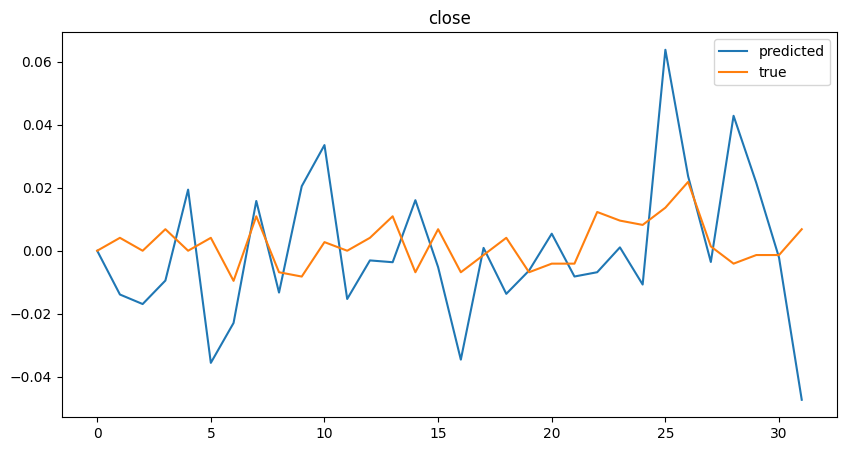

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(result[:, 0].detach().numpy(), label = "Predicted")
plt.plot(label[0, :, 0], label = "True")
plt.legend()
plt.title("Close")
plt.show()

In [11]:
y[:, 0, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

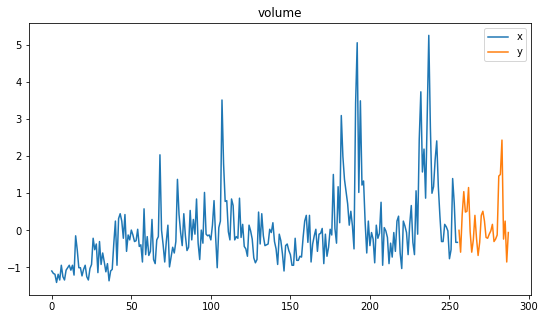

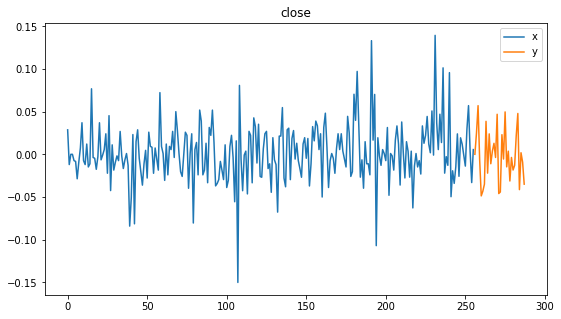

In [15]:
import matplotlib.pyplot as plt

n_seq = 269

src_len = X.shape[1]
tgt_len = y.shape[1]
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 4], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 4], label = "y")
plt.title("volume")
plt.legend()
plt.show()
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 0], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 0], label = "y")
plt.legend()
plt.title("close")
plt.show()

In [8]:
def calculate_batch_cumulative_returns(proj_output, label):

    adjusted_predicted_returns = 1 + proj_output[:, :, 4]
    adjusted_actual_returns = 1 + label[:, :, 4]

    cumulative_predicted_compound_returns = torch.cumprod(adjusted_predicted_returns, dim = -1)
    cumulative_actual_compound_returns = torch.cumprod(adjusted_actual_returns, dim = -1)

    cumulative_predicted_compound_returns -= 1
    cumulative_actual_compound_returns -= 1

    return cumulative_predicted_compound_returns, cumulative_actual_compound_returns 